# GRT Development

This notebook develops some of the key ideas and tools of the new version of GRT

In [74]:
import spiceypy as spy
from matplotlib import pyplot as plt
import pandas as pd
from time import time,strftime
import numpy as np
%matplotlib nbagg
TIME=time()

import tarfile

BDIR=f"./"
DATADIR=f"{BDIR}/data/"
KERDIR=f"{BDIR}/util/kernels/"
FIGDIR=f"{BDIR}/papers/paper1/figures/"

In [2]:
%matplotlib nbagg

## Classes and Routines

### Routines

In [3]:
def elTime(verbose=True):
    global TIME
    t=time()
    dt=t-TIME
    if verbose:print("%.3f s, %.3f min, %g h"%(dt,dt/60.0,dt/3600.0))
    TIME=t

def str2t(date):
    et=spy.str2et(date)
    dt=spy.deltet(et,"ET")
    t=et-dt
    return t
spy.str2t=str2t

class Observer(object):
    """
    lon: longitude, float, radians
    lat: laritude, float, radians
    alt: float, km
    et: TDB in seconds
    """
    _RE=6378.1366 #km, Earth's equatorial radius
    _RP=6356.7519 #km, Earth's polar radius
    _FE=0.0033528131084554717 #Elipticity

    def __init__(self,lon,lat,alt):
        self.lon=lon
        self.lat=lat
        self.alt=alt
        self._positionBody=spy.georec(lon,lat,alt,self._RE,self._FE) 
        self._rho=((self._positionBody[:2]**2).sum())**0.5 #Distance to Earth's axis

        #Minus sign is because local reference frame is: x=North, y=West, z=Up
        #ERROR: This is probably a mistake
        self._velocityLocal=np.array([0,-2*np.pi*self._rho/DAY,0]) 
        self._calcMatrices()
        self._velocityBody=spy.mxv(self._loc2bod,self._velocityLocal)
    
    def _calcMatrices(self):
        uz=spy.surfnm(self._RE,self._RE,self._RP,self._positionBody)
        uy=spy.ucrss(np.array([0,0,1]),uz)
        ux=spy.ucrss(uz,uy)
        self._loc2bod=np.array(np.vstack((ux,uy,uz)).transpose().tolist())
        self._bod2loc=np.linalg.inv(self._loc2bod)
        self._bod2ecl=None
        self._ecl2bod=None
        
    def updateOrientationPosition(self,et):
        self._et=et
        self._bod2ecl=spy.pxform("ITRF93","ECLIPJ2000",et)
        self._ecl2bod=np.linalg.inv(self._bod2ecl)
        self._stateEarth=spy.spkezr("EARTH",et,"ECLIPJ2000","NONE","SSB")[0]
        self._positionEcl=spy.mxv(self._bod2ecl,self._positionBody)
        self._positionEcl=self._positionEcl+self._stateEarth[:3]
        
    def _checkOrientation(self):
        if self._ecl2bod is None:
            raise AssertionError("You must update orientation, eg. observer.updateOrientation(et)")
        
    def ecl2loc(self,eclon,eclat):
        """
        Parameters:
            eclon: Ecliptic longitude, float, radians
            eclat: Ecliptic latitude, float, radians
        Return:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
        """
        self._checkOrientation()
        ecx,ecy,ecz=spy.latrec(1,eclon,eclat)
        x,y,z=spy.mxv(self._bod2loc,spy.mxv(self._ecl2bod,[ecx,ecy,ecz]))
        r,A,h=spy.reclat([x,y,z])
        A=2*np.pi+A if A<0 else A
        return A,h

    def loc2ecl(self,A,h):
        """
        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
        Return:
            eclon: Ecliptic longitude (0,2pi), float, radians
            eclat: Ecliptic latitude (-pi,pi), float, radians
        """
        self._checkOrientation()
        x,y,z=spy.latrec(1,A,h)
        ecx,ecy,ecz=spy.mxv(self._bod2ecl,spy.mxv(self._loc2bod,[x,y,z]))
        r,eclon,eclat=spy.reclat([ecx,ecy,ecz])
        eclon=2*np.pi+eclon if eclon<0 else eclon
        return eclon,eclat

    def vBod2vloc(self,vBod):
        """
        Parameters:
            vBod: Velocity in the body-fixed system, np.array, km/s
        Return:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        """
        vLoc=spy.mxv(self._bod2loc,vBod)
        vloc,A,h=spy.reclat(vLoc)
        A=2*np.pi+A if A<0 else A
        return A,h,vloc
    
    def vloc2vBod(self,A,h,vloc):
        """
        Answer the question: what is the velocity (in the rotating geocentric reference frame) 
        of a particle GOING to A,h at a speed vloc. 
        
        It is VERY important to take into account that if a particle is COMING from A,h, you 
        need to specify its velocity as (A,h,-vloc).

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            vBod: Velocity in the body-fixed system, np.array, km/s
        """
        self._checkOrientation()
        vLoc=spy.latrec(vloc,A,h)
        vBod=spy.mxv(self._loc2bod,vLoc)
        return vBod
    
    def vloc2vRot(self,A,h,vloc):
        """
        Answer the question: what is the velocity (in the non-rotating geocentric reference frame) 
        of a particle GOING from A,h at a speed vloc

        It is VERY important to take into account that if a particle is COMING from A,h, you 
        need to specify its velocity as (A,h,-vloc).

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            vRot: Velocity in the inertial system, body axes, np.array, km/s
        """
        self._checkOrientation()
        vLoc=spy.latrec(vloc,A,h)+self._velocityLocal
        vRot=spy.mxv(self._loc2bod,vLoc)
        return vRot
        
    def vloc2vEcl(self,A,h,vloc):
        """
        Answer the question: what is the velocity (in the heliocentric reference frame) 
        of a particle GOING from A,h to a speed vloc

        It is VERY importante to take into account that if a particle is COMING from A,h, you 
        need to specify its velocity as (A,h,-vloc) or (360-A,h,vloc).

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            vEcl: Velocity in the inertial ecliptic system, np.array, km/s
        """
        vRot=self.vloc2vRot(A,h,vloc)
        vEcl=spy.mxv(self._bod2ecl,vRot)+self._stateEarth[3:]
        return vEcl

    def helioState(self,A,h,vloc):
        """
        Answer the question: what is the heliocentric state of a particle COMING from A,h to a speed vloc

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            geostate: State vector with respect to sun, np.array (6), (km,km,km,km/s,km/s,km/s)
        """
        vEcl=self.vloc2vEcl(A,h,vloc)
        state=np.concatenate((self._positionEcl,vEcl))
        return state

    def geoState(self,A,h,vloc):
        """
        Answer the question: what is the heliocentric state of a particle COMING from A,h to a speed vloc

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            geostate: State vector with respect to geocenter, np.array (6), (km,km,km,km/s,km/s,km/s)
        """
        return self.helioState(A,h,vloc)-self._stateEarth

    
    def vecl2vEcl(self,eclon,eclat,vloc):
        """
        Parameters:
            eclon: Ecliptic longitude (0,2 pi), float, radians
            eclat: Ecliptic latitude (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (0,infty), float, km/s
        Return:
            vEcl: Velocity in the ecliptic system, np.array, km/s
        """
        self._checkOrientation()
        A,h=self.ecl2loc(eclon,eclat)
        vEcl=self.vloc2vEcl(vloc,A,h)
        return vEcl
     
class Angle(object):
    """
    Routines related to angles
    """
    def dms(value):
        """
        Parameters:
            dec: Angle in decimal, float, degree
        Return:
            dms: Angle in dms, tuple/list/array(4), (sign,deg,min,sec)
        """
        sgn=np.sign(value)
        val=np.abs(value)
        deg=np.floor(val)
        rem=(val-deg)*60
        min=np.floor(rem)
        sec=(rem-min)*60
        return (sgn,deg,min,sec)
    def dec(dms):
        """
        Parameters:
            dms: Angle in dms, tuple/list/array(4), (sign,deg,min,sec)
        Return:
            dec: Angle in decimal, float, degree
        """
        return dms[0]*(dms[1]+dms[2]/60.0+dms[3]/3600.0)
    

    
def zappalaDistance(E1,E2):
    """                                                                                                                                                                              
    Zappala (1990), Nervorny & Vokrouhlicky (2006)                                                                                                                                   
    am=(a+at)/2                                                                                                                                                                      
    d2c=1/np.sqrt(am)*(ka*((at-a)/am)**2+ke*(et-e)**2+ki*(sinit-np.sin(i*DEG))**2+kO*(Omega-Ot)**2+kw*(omega-ot)**2)
    Parameters:
        E1: Elements 1, np.array(5), [q(UL),e,i(rad),W(rad),w(rad)]
        E2: Elements 1, np.array(5), [q(UL),e,i(rad),W(rad),w(rad)]
    Return:
        DZ: Zappala distance (when [q]=AU, DZ<0.1 is a good match), float
    """
    #Coefficients
    ka=5./4
    ke=ki=2
    kw=kW=1e-4
    #Elements
    q1,e1,i1,W1,w1=E1[:5]
    q2,e2,i2,W2,w2=E2[:5]
    #Derived elements
    sini1=np.sin(i1)
    sini2=np.sin(i2)
    a1=np.abs(q1/(1-e1))
    a2=np.abs(q2/(1-e2))
    am=(a1+a2)/2
    anm=1/np.sqrt(np.abs(am))
    varpi1=W1+w1
    varpi2=W2+w2
    """
    print("Reference:",E1[:5])
    print("Comparison:",E2[:5])
    print(f"Derived reference: a={a1:g},sini={sini1:g},varpi={varpi1:g}")
    print(f"Derived comparison: a={a2:g},sini={sini2:g},varpi={varpi2:g}")
    print(f"Average: am={am:g},1/sqrt(am)={anm:g}")
    #"""
    #Zappala metric (Zuluaga & Sucerquia, 2018)
    DZ=anm*(ka*(a1-am)**2/am**2+ke*(e1-e2)**2+ki*(sini1-sini2)**2+kW*(W1-W2)**2+kw*(varpi1-varpi2)**2)**0.5

    return DZ

from copy import deepcopy
GLOBAL_OBS=None
def rayOscelt(lon,lat,alt,A,h,vimp,et):
    """
    Compute the orbital elements of a particle impacting on lon, lat, alt at time et
    going towards A, h at speed vimp.
    
    Parameters:
        lon: Longitude, float, degrees
        lat: Latitude, float, degrees
        alt: Altitude, float, km
        A: Azimuth, float, degrees
        h: Elevation, float, degrees
        vimp: Impact speed, float (negative), km/s
    """
    #Prepare observer structure
    global GLOBAL_OBS
    if (GLOBAL_OBS is None) or \
            np.isclose([lon,lat,alt],[GLOBAL_OBS.lon*RAD,GLOBAL_OBS.lat*RAD,GLOBAL_OBS.alt],rtol=1e-5).sum()<3:
        #print("New observer")
        obs=Observer(lon*DEG,lat*DEG,alt)
        obs._RP=obs._RE;obs._calcMatrices() #Correction for error in GravRay
        obs.updateOrientationPosition(et)
        GLOBAL_OBS=deepcopy(obs)
    else:
        #print("Old observer")
        obs=GLOBAL_OBS
        if np.isclose(et,GLOBAL_OBS._et,rtol=1e-10)==False:
            #print("New time")
            obs.updateOrientationPosition(et)
            
    #Simple estimation
    heliostate=obs.helioState(A*DEG,h*DEG,vimp)
    E_sim=spy.oscelt(heliostate,et,MUSUN)
    #Geocentric conic:
    geostate=obs.geoState(A*DEG,h*DEG,vimp)
    rt=spy.vnorm(geostate[:3])
    q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(geostate,et,MUEARTH)
    a=q/(1-e)
    n=np.sqrt(MUEARTH/np.abs(a)**3)
    etp=eto-Mo/n
    #SoI:
    r=1e6
    fd=np.arccos((q*(1+e)/r-1)/e)
    #See: https://space.stackexchange.com/questions/27602/what-is-hyperbolic-eccentric-anomaly-f
    Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
    Md=e*np.sinh(Hd)-Hd
    deltat=Md/n
    #Heliocentric conic:
    earthpos=spy.spkezr("EARTH",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
    geostatet=spy.conics([q,e,i,Omega,omega,Mo,eto,MUEARTH],etp-deltat)
    soipos=geostatet+earthpos
    E_pcon=spy.oscelt(soipos,etp+deltat,MUSUN)
    return E_sim,E_pcon 

## Constants

In [6]:
#Numerical
DEG=np.pi/180
RAD=1/DEG

#Phsyical
ELEV=80.0 #km, Reference elevation
AU=1.4959787070000000e8 #km, value assumed in DE430

#Source: DE421
#https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de421_announcement.pdf
MUSUN=132712440040.944000 #km^3/s^2
MUEARTH=398600.436233 #km^3/s^2
MUMOON=4902.800076 #km^3/s^2
MUEARTHMOON=403503.236310 #km^3/s^2

#Time constants
DAY=86400
YEAR=365.24*DAY

#Kernels
kernels=[
    #Time
    "naif0012.tls",
    #Object properties
    "pck00010.tpc",
    #Planetary positions
    #"de421.bsp",
    "de430.bsp",
    #Earth reference system
    #"earth_720101_070426.bpc","earth_070425_370426_predict.bpc","earth_latest_high_prec_20190910.bpc"
    "earth_latest_high_prec_20161205.bpc"
    ]
for kernel in kernels:spy.furnsh(f"{KERDIR}/{kernel}")

### Chelyabinsk

In [7]:
et=spy.str2t("02/15/2013 03:20:34 UTC")
print(et)
Esim,Epcon=rayOscelt(63.5,54.4,80.0,96.0,17.0,-19.0,et)
Epcon[0]/=AU;Epcon[2:5]*=RAD
q,e,i,W,w=Epcon[:5]
print(q,e,i,W,w)

414170434.0
0.7784401174063338 0.6627485942828372 5.072134791174499 326.57268408157256 118.00326540853665


## Data Reading

In [5]:
tar=tarfile.open(f"{BDIR}/../grt-YearTest.tgz", "r:*")
fname=tar.getnames()[50]
data=np.loadtxt(tar.extractfile(fname))
columns=["N","ET","lat","lon","h","Az","vimp","xobs","yobs","zobs","vxobs","vyobs","vzobs","q","e","i","Omega","omega","M","qapex"]
data=pd.DataFrame(data,columns=columns)
data.describe()

,N,ET,lat,lon,h,Az,vimp,xobs,yobs,zobs,vxobs,vyobs,vzobs,q,e,i,Omega,omega,M,qapex
count,5974.000000,5974.0,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5.974000e+03,5.974000e+03,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000
mean,119.981085,4320000.0,-6.889885,10.433316,27.753223,140.701547,19.749785,-1.305854e+08,7.087333e+07,29237.551994,-15.100936,-26.386871,-0.013976,0.730253,0.678064,16.258746,244.268289,181.305184,106.988654,91.079647
std,68.988857,0.0,37.183886,104.274433,18.095077,103.532831,7.127716,3.727003e+03,3.874595e+03,3499.729155,11.967398,11.976818,12.520490,0.266964,0.594659,15.424432,90.495582,107.044110,308.615991,38.688669
min,1.000000,4320000.0,-79.912800,-170.750000,6.603600,1.650200,12.207000,-1.305917e+08,7.086738e+07,23630.154203,-57.597944,-69.054618,-43.036799,0.004617,0.008124,0.007101,9.861022,0.032613,-2660.811059,1.216421
25%,60.000000,4320000.0,-35.081700,-65.969200,12.313000,45.644000,15.054000,-1.305877e+08,7.086986e+07,26579.098588,-23.787571,-35.124090,-9.472926,0.538887,0.325325,6.195231,151.275722,101.232632,54.195378,61.317929
50%,120.000000,4320000.0,-7.025380,22.296400,20.200000,126.730000,18.084000,-1.305861e+08,7.087380e+07,28992.350411,-15.019644,-26.622098,0.131079,0.834616,0.519911,12.468160,330.680227,179.568742,162.136520,91.450623
75%,180.000000,4320000.0,14.262600,89.986500,42.401000,239.630000,22.955000,-1.305823e+08,7.087632e+07,32027.254251,-6.259532,-17.644177,9.414311,0.963237,0.803654,21.599853,331.327782,266.409039,268.962938,118.503866
max,240.000000,4320000.0,70.195900,175.522000,62.009000,340.080000,43.039000,-1.305793e+08,7.087982e+07,35687.726464,28.618088,16.615438,43.101787,1.006849,4.738611,175.063778,358.669588,359.987995,359.992376,178.260480


## Asymptotic orbit determination

## Numerical determination

In this section we read the information about the results of determining the asymptotic orbit using the numerical integration procedure in the original GRT.

## Simple determination

Here we will attempt to determine the orbital elements starting only on the location of the 

In [449]:
iev=100
event=data.iloc[iev]
obs=Observer(event["lon"]*DEG,event["lat"]*DEG,ELEV)
obs._RP=obs._RE;obs._calcMatrices() #Correcçtion for error in GravRay
obs.updateOrientationPosition(event["ET"])
event["lat"],event["lon"],event["Az"],event["h"],event["vimp"],event["ET"],spy.et2utc(event["ET"],"C",0)

(-16.4228, -29.9483, 1.6502, 56.981, 12.207, 4320000.0, '2000 FEB 20 11:58:56')

In [450]:
#Comparison
opt=(event["Az"])*DEG,event["h"]*DEG,-event["vimp"]
#opt=(360-event["Az"])*DEG,-event["h"]*DEG,event["vimp"]
obs._positionEcl,obs.vloc2vEcl(*opt),\
event[["xobs","yobs","zobs"]].values,event[["vxobs","vyobs","vzobs"]].values

(array([-1.30582607e+08,  7.08678075e+07,  3.03545799e+04]),
 array([-21.15994001, -18.55652399,  -7.13746505]),
 array([-1.30582607e+08,  7.08678075e+07,  3.03545799e+04]),
 array([-21.15990113, -18.55669163,  -7.13767917]))

In [451]:
#Numerically determined
q,e,i,Omega,omega,M=event[["q","e","i","Omega","omega","M"]].values
print(f"q={q} AU,e={e},i={i},W={Omega},w={omega}\nM={M},a={q/(1-e)} AU")

q=0.8600572458010401 AU,e=0.1294093814540304,i=7.450907416751878,W=331.6998734666597,w=78.89875965056892
M=72.28317106246105,a=0.9879008887523714 AU


In [453]:
#Simply determined
heliostate=obs.helioState(event["Az"]*DEG,event["h"]*DEG,-event["vimp"])
q,e,i,Omega,omega,M,et,mu,f,a,P=spy.oscltx(heliostate,event["ET"],MUSUN)
print(f"q={q/AU} AU,e={e},i={i*RAD},W={Omega*RAD},w={omega*RAD}\nM={M*RAD},f={f*RAD},a={a/AU} AU,P={P/YEAR} yr")

q=0.6208004537398066 AU,e=0.3397801182292079,i=15.131354585297741,W=331.55439362800547,w=61.37840100362403
M=80.32341393146227,f=118.57675434604417,a=0.9402934853684538 AU,P=0.9118328486813002 yr


## Patched conics determination

Here we will attempt to determine the orbital elements using a patched conics determination

### Geocentric elements

In [577]:
geostate=obs.geoState(event["Az"]*DEG,event["h"]*DEG,-event["vimp"])
rt=spy.vnorm(geostate[:3])
q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(geostate,event["ET"],MUEARTH)
a=q/(1-e)
n=np.sqrt(MUEARTH/np.abs(a)**3)
etp=eto-Mo/n
print(f"q={q/obs._RE} AU,e={e},i={i*RAD},W={Omega*RAD},w={omega*RAD}\nM={Mo*RAD},\
f={f*RAD},a={a/obs._RE} AU, n={n} rad/s,\nr = {rt} km, tp = {tp} s")

q=0.3416301537782395 AU,e=1.1416531613707535,i=106.80420976777597,W=117.0222726259595,w=279.59907043009747
M=-9.1351513664671,f=101.40219314631362,a=-2.4117368823423555 AU, n=0.00033092781581773895 rad/s,
r = 6456.440295582877 km, tp = 4320481.79228639 s


In [578]:
r=1e6
fd=np.arccos((q*(1+e)/r-1)/e)
Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
Md=e*np.sinh(Hd)-Hd
deltat=Md/n
print(f"f={fd*RAD},H={Hd*RAD},M={Md*RAD},deltat={deltat} s")

f=150.6726073138603,H=272.1774367984908,M=3509.317755306966,deltat=185083.1099750669 s


In [579]:
geostatet=spy.conics([q,e,i,Omega,omega,Mo,eto,MUEARTH],etp-deltat)
q,spy.vnorm(geostatet[:3]),geostate

(2178.9637874766177,
 1000000.0000000293,
 array([ 3053.67473812, -5668.3582563 ,   480.00683585,    -6.320487  ,
            7.64918578,    -7.13638064]))

In [581]:
#Patched conics
earthpos=spy.spkezr("EARTH",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
soipos=geostatet+earthpos
q,e,i,Omega,omega,M,et,mu,f,a,P=spy.oscltx(soipos,etp+deltat,MUSUN)
print(f"Patched Conics: q={q/AU} AU,e={e},i={i*RAD},W={Omega*RAD},w={omega*RAD}\nM={M*RAD},f={f*RAD},a={a/AU} AU,P={P/YEAR} yr")
#Numerically determined
q,e,i,Omega,omega,M=event[["q","e","i","Omega","omega","M"]].values
print(f"Numerical: q={q} AU,e={e},i={i},W={Omega},w={omega}\nM={M},a={q/(1-e)} AU")

Patched Conics: q=0.8563731463836756 AU,e=0.12977516363439923,i=7.5579937986248416,W=331.68568171473754,w=78.4364980970789
M=84.41076286489864,f=99.27970560631498,a=0.9840826308293207 AU,P=0.9762643769210295 yr
Numerical: q=0.8600572458010401 AU,e=0.1294093814540304,i=7.450907416751878,W=331.6998734666597,w=78.89875965056892
M=72.28317106246105,a=0.9879008887523714 AU


### Studying speeds

In [392]:
#Zero-observer
#et=spy.str2et("2000 JAN 01 12:00:00 UTC")
et=spy.str2et("2000 MAR 22 12:00:00 UTC")
sim=Observer(0*DEG,0*DEG,0)
sim.updateOrientationPosition(et)

In [393]:
sim._velocityLocal,sim._velocityBody,sim._loc2bod,sim._bod2ecl

(array([ 0.        , -0.46383118,  0.        ]),
 array([ 0.        , -0.46383118,  0.        ]),
 array([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]]),
 array([[ 9.99986620e-01, -5.17301033e-03, -7.88447915e-06],
        [ 4.74931696e-03,  9.17476861e-01,  3.97760799e-01],
        [-2.05038689e-03, -3.97755514e-01,  9.17489154e-01]]))

In [394]:
sim._stateEarth

array([-1.49976941e+08, -6.16003355e+06,  2.93325853e+04,  6.50583742e-01,
       -2.98798520e+01, -2.35420741e-04])

In [420]:
A=(90.0-23.5)
h=0.0
vimp=-10
vdir=A*DEG,h*DEG,vimp
print("Earth heliograme:",sim._stateEarth[3:])
print("In the rotating geoframe:",sim.vloc2vBod(*vdir))
print("In the non-rotating geoframe:",sim.vloc2vRot(*vdir))
print("In the helioframe:",sim.vloc2vEcl(*vdir))

Earth heliograme: [ 6.50583742e-01 -2.98798520e+01 -2.35420741e-04]
In the rotating geoframe: [-0.         -9.17060074 -3.98749069]
In the non-rotating geoframe: [ 0.         -9.63443193 -3.98749069]
In the helioframe: [  0.7004542  -40.30528784   0.17343355]


Here, we have a mistake.  If a particle in the rotating reference frame have a y-component of -9.17 km/s (going towards the west) it is because in the inertial reference frame have a y-componente of -8.8 km/s.  This is because the rotation velocity of the Earth is toward East.  Therefore to the inertial velocity -8.8 km/s you have to add the rotational velocity 0.4 km/s.

In the original GravRay we have a mistake equivalent to have assumed that the Earth was rotating clockwise.

### Observer class

## Test routines

In [407]:
np.isclose([1,2],[1,2])

array([ True,  True])

In [139]:
import unittest
class Test(unittest.TestCase):
    
    #Zero-observer
    et=spy.str2et("2000 JAN 01 12:00:00 UTC")
    observer=Observer(0*DEG,0*DEG,0)
    observer.updateOrientationPosition(et)

    #Chelyabinsk impact
    etchely=spy.str2et("02/15/2013 3:20:34 UTC")
    chely=Observer(61.1*DEG,54.8*DEG,23.3)
    chely.updateOrientationPosition(etchely)
    
    #Arbitrary impact
    etarb=4320000.0 #Feb. 20/2000, 12:00:00 TDB
    arb=Observer(-29.9483*DEG,-16.4228*DEG,80.0)
    arb._RP=arb._RE;arb._calcMatrices() #Error in GravRay
    arb.updateOrientationPosition(etarb)

    def test_earthpos(self):
        self.assertEqual(np.isclose(self.arb._stateEarth,
                                    np.array([-1.30585661e+08,7.08734759e+07,2.98745730e+04,
                                              -1.48394530e+01,-2.62057098e+01,-1.08440413e-03]),
                                    rtol=1e-5).tolist(),
                         [True]*6)
    
    def test_vrot(self):
        vrot=self.observer.vloc2vRot(90*DEG,0*DEG,10.0)
        self.assertAlmostEqual(vrot[0],0,5)
        self.assertAlmostEqual(vrot[1],9.53616882e+00,5)
        self.assertAlmostEqual(vrot[2],0,5)
        
    def test_arb_position(self):
        self.assertTrue(np.isclose(self.arb._positionEcl[0],-1.30582607e+08,rtol=1e-7,atol=0,equal_nan=False))
        self.assertTrue(np.isclose(self.arb._positionEcl[1],7.08678075e+07,rtol=1e-7,atol=0,equal_nan=False))
        self.assertTrue(np.isclose(self.arb._positionEcl[2],3.03545799e+04,rtol=1e-7,atol=0,equal_nan=False))
        
    def test_arb_velocity(self):
        vecl=self.arb.vloc2vEcl(1.6502*DEG,56.981*DEG,-12.207)
        self.assertTrue(np.isclose(vecl[0],-21.15990113,rtol=1e-4,atol=0,equal_nan=False))
        self.assertTrue(np.isclose(vecl[1],-18.55669163,rtol=1e-4,atol=0,equal_nan=False))
        self.assertTrue(np.isclose(vecl[2],-7.13767917,rtol=1e-4,atol=0,equal_nan=False))
    
    def test_et(self):
        self.assertAlmostEqual(self.et,64.2,1)
        
    def test_ellipsoid(self):
        self.assertAlmostEqual(self.observer._RE,6378.1366,4)
        self.assertAlmostEqual(self.observer._RP,6356.7519,4)
        self.assertAlmostEqual(self.observer._FE,0.0033528131084554717,7)
    
    def test_position(self):
        self.assertEqual(self.observer._positionBody[0],self.observer._RE)
        
    def test_velocity_local(self):
        self.assertAlmostEqual(self.observer._velocityLocal[0],0,5)
        self.assertAlmostEqual(self.observer._velocityLocal[1],-0.46383118,5)
        self.assertAlmostEqual(self.observer._velocityLocal[2],0,5)
        
    def test_ecl2loc_sun(self):
        #Position of the Sun
        eclon=Angle.dec((+1,280,22,21.9))
        eclat=Angle.dec((-1,0,0,2.7))
        A,h=self.observer.ecl2loc(eclon*DEG,eclat*DEG)
        self.assertAlmostEqual(A*RAD,178.07231644928592,5)
        self.assertAlmostEqual(h*RAD,66.95277694576103,5)
    
    def test_ecl2loc_Betelgeuse(self):
        #Betelgeuse
        eclon=Angle.dec((+1,88,45,16.6))
        eclat=Angle.dec((-1,16,1,37.2))
        A,h=self.observer.ecl2loc(eclon*DEG,eclat*DEG)
        self.assertAlmostEqual(A*RAD,57.27518638612843,5)
        self.assertAlmostEqual(h*RAD,-76.20677246845091,5)
    
    def test_loc2ecl_sun(self):
        A=Angle.dec((+1,57,16,30.7))
        h=Angle.dec((-1,76,12,24.4))
        eclon,eclat=self.observer.loc2ecl(A*DEG,h*DEG)
        self.assertAlmostEqual(eclon*RAD,88.75461469860417,5)
        self.assertAlmostEqual(eclat*RAD,-16.027004471139914,5)
        
    def test_chely_et(self):
        self.assertAlmostEqual(self.etchely,414170501.185,3)
        
    def test_chely_vbod2vloc(self):
        vBod=np.array([12.8,-13.3,-2.4])
        A,h,vloc=self.chely.vBod2vloc(-vBod)
        self.assertAlmostEqual(A*RAD,99.8961127649985,5)
        self.assertAlmostEqual(h*RAD,15.92414245029081,5)

    def test_chely_vloc2vbod(self):
        vBod=self.chely.vloc2vBod(279.9*DEG,-15.9*DEG,18.6)
        self.assertAlmostEqual(vBod[0],12.8,1)
        self.assertAlmostEqual(vBod[1],-13.3,1)
        self.assertAlmostEqual(vBod[2],-2.4,1)
        
    def test_chely_elements(self):
        et=spy.str2t("02/15/2013 03:20:34 UTC")
        Esim,Epcon=rayOscelt(63.5,54.4,80.0,96.0,17.0,-19.0,et)
        Epcon[0]/=AU;Epcon[2:5]*=RAD
        q,e,i,W,w=Epcon[:5]
        self.assertEqual(np.isclose([q,e,i,W,w],
                                    [0.78,0.66,5.07,326.57,118.00],
                                     atol=1e-1).tolist(),
                         [True]*5)
        
if __name__=='__main__':
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

...............
----------------------------------------------------------------------
Ran 15 tests in 0.038s

OK


## Comparison Procedure

In [604]:
iev=100
event=data.iloc[iev]
#Elements
q_num,e_num,i_num,W_num,w_num,M_num=event[["q","e","i","Omega","omega","M"]].values
q_num*=AU;i_num*=DEG;W_num*=DEG;w_num*=DEG;M_num*=DEG
#Build observer
obs=Observer(event["lon"]*DEG,event["lat"]*DEG,ELEV)
obs._RP=obs._RE;obs._calcMatrices() #Correcçtion for error in GravRay
obs.updateOrientationPosition(event["ET"])
#Simply determined
heliostate=obs.helioState(event["Az"]*DEG,event["h"]*DEG,-event["vimp"])
q_sim,e_sim,i_sim,W_sim,w_sim,M_sim,et,mu=spy.oscelt(heliostate,event["ET"],MUSUN)
#Patched conics
#Geocentric conic:
geostate=obs.geoState(event["Az"]*DEG,event["h"]*DEG,-event["vimp"])
rt=spy.vnorm(geostate[:3])
q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(geostate,event["ET"],MUEARTH)
a=q/(1-e)
n=np.sqrt(MUEARTH/np.abs(a)**3)
etp=eto-Mo/n
#SoI:
r=1e6
fd=np.arccos((q*(1+e)/r-1)/e)
Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
Md=e*np.sinh(Hd)-Hd
deltat=Md/n
#Heliocentric conic:
earthpos=spy.spkezr("EARTH",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
geostatet=spy.conics([q,e,i,Omega,omega,Mo,eto,MUEARTH],etp-deltat)
soipos=geostatet+earthpos
q_pcon,e_pcon,i_pcon,W_pcon,w_pcon,M_pcon,et,mu=spy.oscelt(soipos,etp+deltat,MUSUN)
q_pcon,e_pcon,i_pcon,W_pcon,w_pcon,M_pcon,et,mu

(128111599.22365727,
 0.12977516363439923,
 0.13191187663131676,
 5.789007227644121,
 1.3689751455282937,
 1.4732457361126428,
 4505564.902261457,
 132712440040.944)

In [606]:
q_pcon,e_pcon,i_pcon,W_pcon,w_pcon,M_pcon,et,mu=patchedOscelt(obs,
                                                              event["Az"],event["h"],-event["vimp"],
                                                              event["ET"])
q_pcon,e_pcon,i_pcon,W_pcon,w_pcon,M_pcon,et,mu

(128111599.22365727,
 0.12977516363439923,
 0.13191187663131676,
 5.789007227644121,
 1.3689751455282937,
 1.4732457361126428,
 4505564.902261457,
 132712440040.944)

In [599]:
def patchedOscelt(observer,A,h,vimp,et):
    #Geocentric conic:
    geostate=observer.geoState(A*DEG,h*DEG,vimp)
    rt=spy.vnorm(geostate[:3])
    q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(geostate,et,MUEARTH)
    a=q/(1-e)
    n=np.sqrt(MUEARTH/np.abs(a)**3)
    etp=eto-Mo/n
    #SoI:
    r=1e6
    fd=np.arccos((q*(1+e)/r-1)/e)
    Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
    Md=e*np.sinh(Hd)-Hd
    deltat=Md/n
    #Heliocentric conic:
    earthpos=spy.spkezr("EARTH",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
    geostatet=spy.conics([q,e,i,Omega,omega,Mo,eto,MUEARTH],etp-deltat)
    soipos=geostatet+earthpos
    return spy.oscelt(soipos,etp+deltat,MUSUN)

In [6]:
from copy import deepcopy
GLOBAL_OBS=None
def rayOscelt(lon,lat,alt,A,h,vimp,et):
    """
    """
    #Prepare observer structure
    global GLOBAL_OBS
    if (GLOBAL_OBS is None) or \
            np.isclose([lon,lat,alt],[GLOBAL_OBS.lon*RAD,GLOBAL_OBS.lat*RAD,GLOBAL_OBS.alt],rtol=1e-5).sum()<3:
        #print("New observer")
        obs=Observer(lon*DEG,lat*DEG,alt)
        obs._RP=obs._RE;obs._calcMatrices() #Correction for error in GravRay
        obs.updateOrientationPosition(et)
        GLOBAL_OBS=deepcopy(obs)
    else:
        #print("Old observer")
        obs=GLOBAL_OBS
        if np.isclose(et,GLOBAL_OBS._et,rtol=1e-10)==False:
            #print("New time")
            obs.updateOrientationPosition(et)
            
    #Simple estimation
    heliostate=obs.helioState(A*DEG,h*DEG,vimp)
    E_sim=spy.oscelt(heliostate,event["ET"],MUSUN)
    #Geocentric conic:
    geostate=obs.geoState(A*DEG,h*DEG,vimp)
    rt=spy.vnorm(geostate[:3])
    q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(geostate,et,MUEARTH)
    a=q/(1-e)
    n=np.sqrt(MUEARTH/np.abs(a)**3)
    etp=eto-Mo/n
    #SoI:
    r=1e6
    fd=np.arccos((q*(1+e)/r-1)/e)
    #See: https://space.stackexchange.com/questions/27602/what-is-hyperbolic-eccentric-anomaly-f
    Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
    Md=e*np.sinh(Hd)-Hd
    deltat=Md/n
    #Heliocentric conic:
    earthpos=spy.spkezr("EARTH",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
    geostatet=spy.conics([q,e,i,Omega,omega,Mo,eto,MUEARTH],etp-deltat)
    soipos=geostatet+earthpos
    E_pcon=spy.oscelt(soipos,etp+deltat,MUSUN)
    return E_sim,E_pcon 

In [164]:
iev=100
event=data.iloc[iev]
E_sim,E_pcon=rayOscelt(event["lon"],event["lat"],80.0,event["Az"],event["h"],-event["vimp"],event["ET"])

In [148]:
%timeit -n 1000 rayOscelt(event["lon"],event["lat"],80.0,event["Az"],event["h"],-event["vimp"],event["ET"])

1000 loops, best of 3: 732 µs per loop


In C++ the numerical determination takes 75-86 msec.  In Python it takes 0.5-0.6 msec (without the simple estimation).  This implies an improvement in a factor of ~200 using even python

## Systematic comparison

In [10]:
def zappalaDistance(E1,E2):
    """                                                                                                                                                                              
    Zappala (1990), Nervorny & Vokrouhlicky (2006)                                                                                                                                   
    am=(a+at)/2                                                                                                                                                                      
    d2c=1/np.sqrt(am)*(ka*((at-a)/am)**2+ke*(et-e)**2+ki*(sinit-np.sin(i*DEG))**2+kO*(Omega-Ot)**2+kw*(omega-ot)**2)
    Parameters:
        E1: [q(UL),e,i(rad),W(rad),w(rad)]
    
    """
    ka=5./4
    ke=ki=2
    kw=kW=1e-4
    #Elements
    q1,e1,i1,W1,w1=E1[:5]
    q2,e2,i2,W2,w2=E2[:5]
    #Derived elements
    sini1=np.sin(i1)
    sini2=np.sin(i2)
    a1=q1/(1-e1)
    a2=q2/(1-e2)
    am=(a1+a2)/2
    anm=1/np.sqrt(np.abs(am))
    varpi1=W1+w1
    varpi2=W2+w2
    """
    print("Reference:",E1[:5])
    print("Comparison:",E2[:5])
    print(f"Derived reference: a={a1:g},sini={sini1:g},varpi={varpi1:g}")
    print(f"Derived comparison: a={a2:g},sini={sini2:g},varpi={varpi2:g}")
    print(f"Average: am={am:g},1/sqrt(am)={anm:g}")
    """
    #Metric (Zuluaga & Sucerquia, 2018)
    DZ=anm*(ka*(a1-am)**2/am**2+ke*(e1-e2)**2+ki*(sini1-sini2)**2+kW*(W1-W2)**2+kw*(varpi1-varpi2)**2)**0.5

    return DZ

In [41]:
tar=tarfile.open(f"{BDIR}/../grt-YearTest.tgz", "r:*")
fname=tar.getnames()[50]
data=np.loadtxt(tar.extractfile(fname))
columns=["N","ET","lat","lon","h","Az","vimp","xobs","yobs","zobs","vxobs","vyobs","vzobs","q","e","i","Omega","omega","M","qapex"]
data=pd.DataFrame(data,columns=columns)
data.describe()

,N,ET,lat,lon,h,Az,vimp,xobs,yobs,zobs,vxobs,vyobs,vzobs,q,e,i,Omega,omega,M,qapex
count,5974.000000,5974.0,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5.974000e+03,5.974000e+03,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000
mean,119.981085,4320000.0,-6.889885,10.433316,27.753223,140.701547,19.749785,-1.305854e+08,7.087333e+07,29237.551994,-15.100936,-26.386871,-0.013976,0.730253,0.678064,16.258746,244.268289,181.305184,106.988654,91.079647
std,68.988857,0.0,37.183886,104.274433,18.095077,103.532831,7.127716,3.727003e+03,3.874595e+03,3499.729155,11.967398,11.976818,12.520490,0.266964,0.594659,15.424432,90.495582,107.044110,308.615991,38.688669
min,1.000000,4320000.0,-79.912800,-170.750000,6.603600,1.650200,12.207000,-1.305917e+08,7.086738e+07,23630.154203,-57.597944,-69.054618,-43.036799,0.004617,0.008124,0.007101,9.861022,0.032613,-2660.811059,1.216421
25%,60.000000,4320000.0,-35.081700,-65.969200,12.313000,45.644000,15.054000,-1.305877e+08,7.086986e+07,26579.098588,-23.787571,-35.124090,-9.472926,0.538887,0.325325,6.195231,151.275722,101.232632,54.195378,61.317929
50%,120.000000,4320000.0,-7.025380,22.296400,20.200000,126.730000,18.084000,-1.305861e+08,7.087380e+07,28992.350411,-15.019644,-26.622098,0.131079,0.834616,0.519911,12.468160,330.680227,179.568742,162.136520,91.450623
75%,180.000000,4320000.0,14.262600,89.986500,42.401000,239.630000,22.955000,-1.305823e+08,7.087632e+07,32027.254251,-6.259532,-17.644177,9.414311,0.963237,0.803654,21.599853,331.327782,266.409039,268.962938,118.503866
max,240.000000,4320000.0,70.195900,175.522000,62.009000,340.080000,43.039000,-1.305793e+08,7.087982e+07,35687.726464,28.618088,16.615438,43.101787,1.006849,4.738611,175.063778,358.669588,359.987995,359.992376,178.260480


In [151]:
from tqdm import tqdm
DZpcons=[]
DZsims=[]
data["DZpcon"]=0
data["DZsim"]=0
sim_elements=["q_sim","e_sim","i_sim","W_sim","w_sim","M_sim"]
pcon_elements=["q_pcon","e_pcon","i_pcon","W_pcon","w_pcon","M_pcon"]
for i,element in enumerate(sim_elements):
    data[element]=0
    data[pcon_elements[i]]=0
for index in tqdm(data.index):
    event=data.loc[index]
    E_num=event[["q","e","i","Omega","omega","M"]].values
    E_num[2:]*=DEG
    E_sim,E_pcon=rayOscelt(event["lon"],event["lat"],80.0,event["Az"],event["h"],-event["vimp"],event["ET"])
    for E in E_sim,E_pcon:E[0]/=AU;
    data[pcon_elements[i]]=0
    data.loc[index,"DZpcon"]=zappalaDistance(E_num,E_pcon)
    data.loc[index,"DZsim"]=zappalaDistance(E_num,E_sim)
    E_sim[2:]*=RAD
    E_pcon[2:]*=RAD
    for i,element in enumerate(sim_elements):
        data.loc[index,element]=E_sim[i]
        data.loc[index,pcon_elements[i]]=E_pcon[i]
    #print(f"Patched conics: {DZpcon:g}, Simple approximation: {DZsim:g}")

100%|██████████| 5974/5974 [01:39<00:00, 59.94it/s]


In [153]:
data[["DZpcon","DZsim","e","e_sim","e_pcon"]].describe()

,DZpcon,DZsim,e,e_sim,e_pcon
count,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000
mean,0.016930,0.287523,0.678064,0.862319,0.683169
std,0.034537,0.131507,0.594659,0.628655,0.597578
min,0.000856,0.020201,0.008124,0.002053,0.008957
25%,0.010545,0.190716,0.325325,0.487567,0.329974
50%,0.014118,0.273329,0.519911,0.694887,0.524848
75%,0.018372,0.369654,0.803654,1.021418,0.809222
max,2.158798,2.208257,4.738611,4.991815,4.751105


In [154]:
data.sort_values(by="DZpcon",ascending=False)[["DZpcon",
                                               "q","q_pcon","e","e_pcon","i","i_pcon",
                                               "Omega","W_pcon","omega","w_pcon"]].head(100)

,DZpcon,q,q_pcon,e,e_pcon,i,i_pcon,Omega,W_pcon,omega,w_pcon
1474,2.158798,0.016877,0.025713,0.527252,0.951372,57.067709,54.042178,139.847971,151.503868,160.715483,176.399796
5275,0.679097,0.044634,0.053040,0.866663,0.943639,92.181199,90.188444,147.611547,151.510124,188.811122,198.258603
4015,0.600337,0.096738,0.104527,0.674379,0.812383,6.020665,6.019212,149.988782,151.390075,186.879973,185.145701
2107,0.581695,0.087156,0.096889,0.702529,0.822261,3.306270,3.309817,151.064288,151.362422,174.833879,179.694104
2781,0.495592,0.097212,0.106778,0.701729,0.808338,19.827119,19.627998,149.448069,151.488004,181.706937,184.758338
3338,0.469054,0.071980,0.083537,0.773614,0.845498,9.047496,8.916927,149.689107,151.441196,172.093446,177.714938
34,0.454219,0.096432,0.104738,0.714017,0.810415,17.462891,17.570545,149.176380,151.476921,190.587877,183.336679
672,0.266840,0.079356,0.090214,0.806693,0.841194,17.364095,17.053206,149.893103,151.480929,183.365399,188.151272
358,0.233240,0.906751,0.876462,3.792993,3.699038,1.286220,1.392040,143.521795,151.090379,335.515198,328.710485
5921,0.172161,0.311437,0.271939,0.524334,0.570495,15.395040,10.393353,151.427750,151.460622,176.508079,177.719708


In [75]:
sort_data=data.sort_values(by="DZpcon",ascending=False)[["DZpcon",
                                                         "q","q_pcon","e","e_pcon","i","i_pcon",
                                                         "Omega","W_pcon","omega","w_pcon"]]

In [159]:
len(data),(data["DZpcon"]>0.1).sum(),(data["DZsim"]>0.1).sum()

(5974, 16, 5680)

In [94]:
def zappalaDistance(E1,E2):
    """                                                                                                                                                                              
    Zappala (1990), Nervorny & Vokrouhlicky (2006)                                                                                                                                   
    am=(a+at)/2                                                                                                                                                                      
    d2c=1/np.sqrt(am)*(ka*((at-a)/am)**2+ke*(et-e)**2+ki*(sinit-np.sin(i*DEG))**2+kO*(Omega-Ot)**2+kw*(omega-ot)**2)
    Parameters:
        E1: [q(UL),e,i(rad),W(rad),w(rad)]
    
    """
    ka=5./4
    ke=ki=2
    kw=kW=1e-4
    #Elements
    q1,e1,i1,W1,w1=E1[:5]
    q2,e2,i2,W2,w2=E2[:5]
    #Derived elements
    sini1=np.sin(i1)
    sini2=np.sin(i2)
    a1=np.abs(q1/(1-e1))
    a2=np.abs(q2/(1-e2))
    am=(a1+a2)/2
    anm=1/np.sqrt(np.abs(am))
    varpi1=W1+w1
    varpi2=W2+w2
    """
    print("Reference:",E1[:5])
    print("Comparison:",E2[:5])
    print(f"Derived reference: a={a1:g},sini={sini1:g},varpi={varpi1:g}")
    print(f"Derived comparison: a={a2:g},sini={sini2:g},varpi={varpi2:g}")
    print(f"Average: am={am:g},1/sqrt(am)={anm:g}")
    #"""
    #Metric (Zuluaga & Sucerquia, 2018)
    DZ=anm*(ka*(a1-am)**2/am**2+ke*(e1-e2)**2+ki*(sini1-sini2)**2+kW*(W1-W2)**2+kw*(varpi1-varpi2)**2)**0.5

    return DZ

In [91]:
zappalaDistance(sort_data[["q","e","i","Omega","omega"]].iloc[0].values,
                sort_data[["q_pcon","e_pcon","i_pcon","W_pcon","w_pcon"]].iloc[0].values)

Reference: [  0.98586762   0.99349446   5.97355373 331.55818135 186.43354859]
Comparison: [  0.99026818   1.00577883   5.95345928 331.62496599 186.04676179]
Derived reference: a=151.543,sini=-0.304708,varpi=517.992
Derived comparison: a=171.361,sini=-0.323784,varpi=517.672
Average: am=161.452,1/sqrt(am)=0.0787006


0.005967290586121318

### Test Chelyabinsk

In [146]:
#Zuluaga & Ferrin (2013)
et=spy.str2et("02/15/2013 03:20:34 UTC")
Esim,Epcon=rayOscelt(63.5,54.4,80.0,96.0,17.0,-19.0,et)
Epcon[0]/=AU;Epcon[2:5]*=RAD
q,e,i,W,w=Epcon[:5]
print(q,e,i,W,w)

0.7800912010958441 0.6657384288180141 5.014260229541216 326.57335661766507 118.36851018829839


In [150]:
#CNEOS
et=spy.str2et("02/15/2013 03:20:33 UTC")
Esim,Epcon=rayOscelt(61.1,54.8,23.3,99.9,15.9,-18.6,et)
Epcon[0]/=AU;Epcon[2:5]*=RAD
q,e,i,W,w=Epcon[:5]
print(q,e,i,W,w)

0.7442325002224244 0.589106931814524 4.300367832565317 326.57239205199164 109.645303527889


In [169]:
selcols=["h","Az",
         "DZpcon","DZsim",
         "q","q_pcon","q_sim",
         "e","e_pcon","e_sim",
         "i","i_pcon","i_sim",
         "Omega","W_pcon","W_sim",
         "omega","w_pcon","w_sim"]
np.savetxt(f"{BDIR}/../grt-YearTest/grtcomp.data",data[selcols].values)

In [167]:
data.columns

Index(['N', 'ET', 'lat', 'lon', 'h', 'Az', 'vimp', 'xobs', 'yobs', 'zobs',
       'vxobs', 'vyobs', 'vzobs', 'q', 'e', 'i', 'Omega', 'omega', 'M',
       'qapex', 'DZpcon', 'DZsim', 'q_sim', 'q_pcon', 'e_sim', 'e_pcon',
       'i_sim', 'i_pcon', 'W_sim', 'W_pcon', 'w_sim', 'w_pcon', 'M_sim',
       'M_pcon'],
      dtype='object')

### Save analysis

In [10]:
tar=tarfile.open(f"{BDIR}/../grt-YearTest.tgz", "r:*")

In [26]:
from tqdm import tqdm
import random

#Read data
adata=None
ierr=0
Nsel=1000
for ntar in range(len(tar.getnames())):
                  
    print(f"Reading file {ntar}...")
    fname=tar.getnames()[ntar]
    data=np.loadtxt(tar.extractfile(fname))
    columns=["N","ET","lat","lon","h","Az","vimp",
             "xobs","yobs","zobs","vxobs","vyobs","vzobs",
             "q","e","i","Omega","omega","M","qapex"]
    data=pd.DataFrame(data,columns=columns)

    #Initialize extracolumns
    data["DZpcon"]=0
    data["DZsim"]=0
    sim_elements=["q_sim","e_sim","i_sim","W_sim","w_sim","M_sim"]
    pcon_elements=["q_pcon","e_pcon","i_pcon","W_pcon","w_pcon","M_pcon"]
    for i,element in enumerate(sim_elements):
        data[element]=0
        data[pcon_elements[i]]=0
        
    #Compute distances
    #for index in tqdm(data.index):
    idata=pd.DataFrame([],columns=data.columns)
    for index in tqdm(random.sample(data.index.values.tolist(),k=Nsel)):
        event=data.loc[index]
        E_num=event[["q","e","i","Omega","omega","M"]].values
        E_num[2:]*=DEG
        E_sim,E_pcon=rayOscelt(event["lon"],event["lat"],80.0,event["Az"],event["h"],-event["vimp"],event["ET"])
        for E in E_sim,E_pcon:E[0]/=AU;
        idata.loc[index]=data.loc[index]
        idata[pcon_elements[i]]=0
        idata.loc[index,"DZpcon"]=zappalaDistance(E_num,E_pcon)
        idata.loc[index,"DZsim"]=zappalaDistance(E_num,E_sim)
        E_sim[2:]*=RAD
        E_pcon[2:]*=RAD
        for i,element in enumerate(sim_elements):
            idata.loc[index,element]=E_sim[i]
            idata.loc[index,pcon_elements[i]]=E_pcon[i]
        #print(f"Patched conics: {DZpcon:g}, Simple approximation: {DZsim:g}")
        #break
    selcols=["ET","lon","lat","h","Az",
             "DZpcon","DZsim",
             "q","q_pcon","q_sim",
             "e","e_pcon","e_sim",
             "i","i_pcon","i_sim",
             "Omega","W_pcon","W_sim",
             "omega","w_pcon","w_sim"]
    fname=f"grtcomp-{ntar:04d}-ET{np.int(event['ET']):010d}.data"
    print(f"\tSaving {fname}...")
    nlarge=(idata["DZpcon"]>0.1).sum()
    ierr+=nlarge
    ndata=len(idata)
    print(f"\tLarge distances: {nlarge}/{ndata}")
    print(f"\tDZ Statistics: (min,mean,std,max)={idata['DZpcon'].min():g},{idata['DZpcon'].mean():g},{idata['DZpcon'].std():g},{idata['DZpcon'].max():g}")
    np.savetxt(f"{BDIR}/../grt-YearTest/{fname}",idata[selcols].values)
    if adata is None:
          adata=pd.DataFrame([],columns=idata[selcols].columns)
    adata=pd.concat((adata,idata[selcols]))
    del(data,idata)
    #if ntar>0:break

print(f"Mismatches: {ierr}/{(ntar+1)*Nsel} = {ierr/((ntar+1.0)*Nsel)*100:g}%")

Reading file 0...


100%|██████████| 1000/1000 [00:13<00:00, 72.74it/s]


	Saving grtcomp-0000-ET0000000000.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000135037,0.0104723,0.0220602,0.355166
Reading file 1...


100%|██████████| 1000/1000 [00:13<00:00, 74.76it/s]


	Saving grtcomp-0001-ET0000086400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000231969,0.0109362,0.0170917,0.292181
Reading file 2...


100%|██████████| 1000/1000 [00:13<00:00, 72.40it/s]


	Saving grtcomp-0002-ET0000172800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000219126,0.0114909,0.0284337,0.750846
Reading file 3...


100%|██████████| 1000/1000 [00:14<00:00, 75.58it/s]


	Saving grtcomp-0003-ET0000259200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000313804,0.0098146,0.012126,0.155946
Reading file 4...


100%|██████████| 1000/1000 [00:13<00:00, 72.34it/s]


	Saving grtcomp-0004-ET0000345600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=7.39344e-05,0.0102749,0.014818,0.209482
Reading file 5...


100%|██████████| 1000/1000 [00:13<00:00, 75.90it/s]


	Saving grtcomp-0005-ET0000432000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000257952,0.0108104,0.0173314,0.371344
Reading file 6...


100%|██████████| 1000/1000 [00:13<00:00, 71.95it/s]


	Saving grtcomp-0006-ET0000518400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000204093,0.0118237,0.0452619,1.33738
Reading file 7...


100%|██████████| 1000/1000 [00:14<00:00, 70.60it/s]


	Saving grtcomp-0007-ET0000604800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=5.81013e-05,0.0107324,0.0135361,0.198353
Reading file 8...


100%|██████████| 1000/1000 [00:15<00:00, 65.23it/s]


	Saving grtcomp-0008-ET0000691200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000167307,0.0104923,0.0131034,0.213162
Reading file 9...


100%|██████████| 1000/1000 [00:13<00:00, 71.48it/s]


	Saving grtcomp-0009-ET0000777600.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000333551,0.0115361,0.0237509,0.443066
Reading file 10...


100%|██████████| 1000/1000 [00:12<00:00, 78.91it/s]


	Saving grtcomp-0010-ET0000864000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000188837,0.011016,0.0208179,0.553939
Reading file 11...


100%|██████████| 1000/1000 [00:13<00:00, 75.10it/s]


	Saving grtcomp-0011-ET0000950400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000233621,0.0114601,0.0257819,0.594527
Reading file 12...


100%|██████████| 1000/1000 [00:13<00:00, 74.11it/s]


	Saving grtcomp-0012-ET0001036800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00040139,0.0112668,0.0175434,0.439232
Reading file 13...


100%|██████████| 1000/1000 [00:14<00:00, 71.38it/s]


	Saving grtcomp-0013-ET0001123200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000139075,0.0121802,0.0161488,0.286197
Reading file 14...


100%|██████████| 1000/1000 [00:13<00:00, 72.25it/s]


	Saving grtcomp-0014-ET0001209600.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.00010859,0.0128515,0.0335721,0.920152
Reading file 15...


100%|██████████| 1000/1000 [00:14<00:00, 68.97it/s]


	Saving grtcomp-0015-ET0001296000.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000326215,0.0126501,0.0271425,0.582202
Reading file 16...


100%|██████████| 1000/1000 [00:14<00:00, 68.96it/s]


	Saving grtcomp-0016-ET0001382400.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000455518,0.0121546,0.0160598,0.229696
Reading file 17...


100%|██████████| 1000/1000 [00:14<00:00, 68.18it/s]


	Saving grtcomp-0017-ET0001468800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000333244,0.0118183,0.0128301,0.18258
Reading file 18...


100%|██████████| 1000/1000 [00:13<00:00, 71.68it/s]


	Saving grtcomp-0018-ET0001555200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000406802,0.0120851,0.0178502,0.324472
Reading file 19...


100%|██████████| 1000/1000 [00:13<00:00, 74.92it/s]


	Saving grtcomp-0019-ET0001641600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000245775,0.0124435,0.022865,0.449412
Reading file 20...


100%|██████████| 1000/1000 [00:13<00:00, 77.93it/s]


	Saving grtcomp-0020-ET0001728000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000528945,0.0123443,0.012362,0.142459
Reading file 21...


100%|██████████| 1000/1000 [00:12<00:00, 77.63it/s]


	Saving grtcomp-0021-ET0001814400.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.000756428,0.0134301,0.0201146,0.423703
Reading file 22...


100%|██████████| 1000/1000 [00:13<00:00, 76.70it/s]


	Saving grtcomp-0022-ET0001900800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00078511,0.0136323,0.0220638,0.535103
Reading file 23...


100%|██████████| 1000/1000 [00:13<00:00, 75.26it/s]


	Saving grtcomp-0023-ET0001987200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000528198,0.0124396,0.0131601,0.191999
Reading file 24...


100%|██████████| 1000/1000 [00:14<00:00, 70.68it/s]


	Saving grtcomp-0024-ET0002073600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00105225,0.0139817,0.0254809,0.581521
Reading file 25...


100%|██████████| 1000/1000 [00:13<00:00, 75.82it/s]


	Saving grtcomp-0025-ET0002160000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000900905,0.0123839,0.0124587,0.217268
Reading file 26...


100%|██████████| 1000/1000 [00:13<00:00, 75.35it/s]


	Saving grtcomp-0026-ET0002246400.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000247661,0.0134726,0.0205829,0.486811
Reading file 27...


100%|██████████| 1000/1000 [00:13<00:00, 74.47it/s]


	Saving grtcomp-0027-ET0002332800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000321695,0.0137167,0.016691,0.3071
Reading file 28...


100%|██████████| 1000/1000 [00:12<00:00, 77.86it/s]


	Saving grtcomp-0028-ET0002419200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000865587,0.0132594,0.0138006,0.266463
Reading file 29...


100%|██████████| 1000/1000 [00:12<00:00, 81.64it/s]


	Saving grtcomp-0029-ET0002505600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000551647,0.0131858,0.0119691,0.153021
Reading file 30...


100%|██████████| 1000/1000 [00:12<00:00, 82.67it/s]


	Saving grtcomp-0030-ET0002592000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000645813,0.0131642,0.0124783,0.172967


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 31...


100%|██████████| 1000/1000 [00:12<00:00, 81.81it/s]


	Saving grtcomp-0031-ET0002678400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000864467,0.0141449,0.0189353,0.48686
Reading file 32...


100%|██████████| 1000/1000 [00:12<00:00, 82.72it/s]


	Saving grtcomp-0032-ET0002764800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000643821,0.013349,0.0106423,0.154875
Reading file 33...


100%|██████████| 1000/1000 [00:12<00:00, 82.64it/s]


	Saving grtcomp-0033-ET0002851200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000833513,0.0149263,0.0272391,0.588748
Reading file 34...


100%|██████████| 1000/1000 [00:12<00:00, 81.70it/s]


	Saving grtcomp-0034-ET0002937600.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000654403,0.0138291,0.0114332,0.135665
Reading file 35...


100%|██████████| 1000/1000 [00:12<00:00, 82.55it/s]


	Saving grtcomp-0035-ET0003024000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00090858,0.0139473,0.0116831,0.15801
Reading file 36...


100%|██████████| 1000/1000 [00:12<00:00, 81.64it/s]


	Saving grtcomp-0036-ET0003110400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000648298,0.014762,0.0146625,0.223641
Reading file 37...


100%|██████████| 1000/1000 [00:12<00:00, 81.93it/s]


	Saving grtcomp-0037-ET0003196800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000548451,0.0149071,0.0230572,0.641238
Reading file 38...


100%|██████████| 1000/1000 [00:12<00:00, 82.43it/s]


	Saving grtcomp-0038-ET0003283200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000833431,0.0152758,0.0242664,0.655866
Reading file 39...


100%|██████████| 1000/1000 [00:12<00:00, 81.70it/s]


	Saving grtcomp-0039-ET0003369600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000755488,0.0148541,0.0164843,0.330812
Reading file 40...


100%|██████████| 1000/1000 [00:12<00:00, 82.68it/s]


	Saving grtcomp-0040-ET0003456000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.0011453,0.0166404,0.0503579,1.5705
Reading file 41...


100%|██████████| 1000/1000 [00:12<00:00, 82.52it/s]


	Saving grtcomp-0041-ET0003542400.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000625284,0.0179856,0.0502067,1.22205
Reading file 42...


100%|██████████| 1000/1000 [00:12<00:00, 82.59it/s]


	Saving grtcomp-0042-ET0003628800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000643499,0.0163195,0.031063,0.701963
Reading file 43...


100%|██████████| 1000/1000 [00:11<00:00, 83.79it/s]


	Saving grtcomp-0043-ET0003715200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000870882,0.0153865,0.0156545,0.391173
Reading file 44...


100%|██████████| 1000/1000 [00:12<00:00, 83.24it/s]


	Saving grtcomp-0044-ET0003801600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000926931,0.0158002,0.0223952,0.637875
Reading file 45...


100%|██████████| 1000/1000 [00:13<00:00, 76.25it/s]


	Saving grtcomp-0045-ET0003888000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00137685,0.0161157,0.0228281,0.542024
Reading file 46...


100%|██████████| 1000/1000 [00:12<00:00, 77.07it/s]


	Saving grtcomp-0046-ET0003974400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00114344,0.0155019,0.0200659,0.565607
Reading file 47...


100%|██████████| 1000/1000 [00:14<00:00, 70.51it/s]


	Saving grtcomp-0047-ET0004060800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00111404,0.0162909,0.0205124,0.579296
Reading file 48...


100%|██████████| 1000/1000 [00:12<00:00, 78.70it/s]


	Saving grtcomp-0048-ET0004147200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.0011422,0.0161924,0.0203781,0.571256
Reading file 49...


100%|██████████| 1000/1000 [00:12<00:00, 81.20it/s]


	Saving grtcomp-0049-ET0004233600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00109662,0.0164682,0.0194953,0.523699


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 50...


100%|██████████| 1000/1000 [00:12<00:00, 82.43it/s]


	Saving grtcomp-0050-ET0004320000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00131802,0.0163939,0.021586,0.600337
Reading file 51...


100%|██████████| 1000/1000 [00:12<00:00, 83.02it/s]


	Saving grtcomp-0051-ET0004406400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00138748,0.0167819,0.0165434,0.409865
Reading file 52...


100%|██████████| 1000/1000 [00:12<00:00, 82.29it/s]


	Saving grtcomp-0052-ET0004492800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00125847,0.0166149,0.0110298,0.122595


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 53...


100%|██████████| 1000/1000 [00:12<00:00, 81.90it/s]


	Saving grtcomp-0053-ET0004579200.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00112979,0.0160186,0.0101504,0.112339


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 54...


100%|██████████| 1000/1000 [00:12<00:00, 82.27it/s]


	Saving grtcomp-0054-ET0004665600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00142683,0.0170631,0.0169445,0.318944
Reading file 55...


100%|██████████| 1000/1000 [00:12<00:00, 82.01it/s]


	Saving grtcomp-0055-ET0004752000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000777042,0.0168771,0.020958,0.59449
Reading file 56...


100%|██████████| 1000/1000 [00:12<00:00, 81.82it/s]


	Saving grtcomp-0056-ET0004838400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000909133,0.0182753,0.019491,0.344772
Reading file 57...


100%|██████████| 1000/1000 [00:12<00:00, 82.01it/s]


	Saving grtcomp-0057-ET0004924800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000899839,0.0165094,0.0114399,0.185706
Reading file 58...


100%|██████████| 1000/1000 [00:12<00:00, 83.06it/s]


	Saving grtcomp-0058-ET0005011200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000826503,0.0171278,0.0203447,0.540904


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 59...


100%|██████████| 1000/1000 [00:12<00:00, 82.58it/s]


	Saving grtcomp-0059-ET0005097600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000911965,0.0178436,0.0229896,0.592717
Reading file 60...


100%|██████████| 1000/1000 [00:12<00:00, 78.43it/s]


	Saving grtcomp-0060-ET0005184000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00118245,0.0176226,0.0179995,0.478138
Reading file 61...


100%|██████████| 1000/1000 [00:12<00:00, 82.16it/s]


	Saving grtcomp-0061-ET0005270400.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000865414,0.0170844,0.0112091,0.109466
Reading file 62...


100%|██████████| 1000/1000 [00:12<00:00, 82.83it/s]


	Saving grtcomp-0062-ET0005356800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000765639,0.0180748,0.017874,0.46582


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 63...


100%|██████████| 1000/1000 [00:12<00:00, 82.66it/s]


	Saving grtcomp-0063-ET0005443200.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000778594,0.0172525,0.0100558,0.0709839
Reading file 64...


100%|██████████| 1000/1000 [00:12<00:00, 81.00it/s]


	Saving grtcomp-0064-ET0005529600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00069674,0.0173088,0.0134027,0.229563
Reading file 65...


100%|██████████| 1000/1000 [00:12<00:00, 83.21it/s]


	Saving grtcomp-0065-ET0005616000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00103465,0.0181805,0.0177271,0.40596


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 66...


100%|██████████| 1000/1000 [00:12<00:00, 82.66it/s]


	Saving grtcomp-0066-ET0005702400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00065124,0.0189098,0.0231268,0.627869
Reading file 67...


100%|██████████| 1000/1000 [00:12<00:00, 80.34it/s]


	Saving grtcomp-0067-ET0005788800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00104532,0.0183244,0.0220816,0.631592
Reading file 68...


100%|██████████| 1000/1000 [00:12<00:00, 82.23it/s]


	Saving grtcomp-0068-ET0005875200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000575846,0.0181809,0.0118433,0.138783
Reading file 69...


100%|██████████| 1000/1000 [00:12<00:00, 82.67it/s]


	Saving grtcomp-0069-ET0005961600.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000545791,0.0186961,0.0224107,0.638794
Reading file 70...


100%|██████████| 1000/1000 [00:12<00:00, 83.32it/s]


	Saving grtcomp-0070-ET0006048000.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.00137165,0.0182091,0.0108165,0.0757311
Reading file 71...


100%|██████████| 1000/1000 [00:12<00:00, 84.97it/s]


	Saving grtcomp-0071-ET0006134400.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000969541,0.0186254,0.0122631,0.157163
Reading file 72...


100%|██████████| 1000/1000 [00:12<00:00, 81.89it/s]


	Saving grtcomp-0072-ET0006220800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000747668,0.0192423,0.0245881,0.622457
Reading file 73...


100%|██████████| 1000/1000 [00:12<00:00, 81.61it/s]


	Saving grtcomp-0073-ET0006307200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000697187,0.0191474,0.0169764,0.426429


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 74...


100%|██████████| 1000/1000 [00:12<00:00, 82.20it/s]


	Saving grtcomp-0074-ET0006393600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00111455,0.018549,0.0189873,0.500503
Reading file 75...


100%|██████████| 1000/1000 [00:12<00:00, 83.04it/s]


	Saving grtcomp-0075-ET0006480000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000619814,0.0196758,0.0200289,0.530788


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 76...


100%|██████████| 1000/1000 [00:12<00:00, 82.11it/s]


	Saving grtcomp-0076-ET0006566400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000599693,0.0193574,0.0276333,0.570324


100%|██████████| 1000/1000 [00:12<00:00, 82.78it/s]


Reading file 77...
	Saving grtcomp-0077-ET0006652800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000587506,0.0209301,0.0281416,0.603787


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 78...


100%|██████████| 1000/1000 [00:12<00:00, 83.33it/s]


	Saving grtcomp-0078-ET0006739200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00152843,0.0195925,0.027574,0.785348
Reading file 79...


100%|██████████| 1000/1000 [00:12<00:00, 82.79it/s]


	Saving grtcomp-0079-ET0006825600.data...
	Large distances: 11/1000
	DZ Statistics: (min,mean,std,max)=0.000522913,0.0199789,0.0154411,0.156169


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 80...


100%|██████████| 1000/1000 [00:12<00:00, 83.03it/s]


	Saving grtcomp-0080-ET0006912000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000379726,0.0203243,0.0248146,0.692168
Reading file 81...


100%|██████████| 1000/1000 [00:12<00:00, 82.47it/s]


	Saving grtcomp-0081-ET0006998400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000227964,0.0196246,0.0126894,0.107606
Reading file 82...


100%|██████████| 1000/1000 [00:12<00:00, 83.08it/s]


	Saving grtcomp-0082-ET0007084800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000443576,0.0191088,0.0128778,0.165669
Reading file 83...


100%|██████████| 1000/1000 [00:12<00:00, 86.48it/s]


	Saving grtcomp-0083-ET0007171200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000995203,0.019945,0.0232984,0.599841
Reading file 84...


100%|██████████| 1000/1000 [00:13<00:00, 72.58it/s]


	Saving grtcomp-0084-ET0007257600.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000832032,0.0189958,0.011393,0.0688515
Reading file 85...


100%|██████████| 1000/1000 [00:12<00:00, 80.86it/s]


	Saving grtcomp-0085-ET0007344000.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000916351,0.0192396,0.0105194,0.0808357
Reading file 86...


100%|██████████| 1000/1000 [00:12<00:00, 80.84it/s]


	Saving grtcomp-0086-ET0007430400.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000449678,0.0193154,0.0133236,0.216884


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 87...


100%|██████████| 1000/1000 [00:12<00:00, 82.45it/s]


	Saving grtcomp-0087-ET0007516800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000573943,0.0196459,0.0199215,0.488228


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 88...


100%|██████████| 1000/1000 [00:12<00:00, 82.43it/s]


	Saving grtcomp-0088-ET0007603200.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000535612,0.0197061,0.0124628,0.126485
Reading file 89...


100%|██████████| 1000/1000 [00:12<00:00, 82.84it/s]


	Saving grtcomp-0089-ET0007689600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000651049,0.0197438,0.0141504,0.206485
Reading file 90...


100%|██████████| 1000/1000 [00:12<00:00, 82.95it/s]


	Saving grtcomp-0090-ET0007776000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00114085,0.019584,0.0145151,0.273114
Reading file 91...


100%|██████████| 1000/1000 [00:12<00:00, 82.39it/s]


	Saving grtcomp-0091-ET0007862400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000691895,0.0209871,0.0326733,0.889016
Reading file 92...


100%|██████████| 1000/1000 [00:12<00:00, 82.49it/s]


	Saving grtcomp-0092-ET0007948800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000724813,0.019237,0.0121306,0.115783


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 93...


100%|██████████| 1000/1000 [00:12<00:00, 82.47it/s]


	Saving grtcomp-0093-ET0008035200.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00063425,0.0200467,0.0124512,0.111352
Reading file 94...


100%|██████████| 1000/1000 [00:12<00:00, 79.90it/s]


	Saving grtcomp-0094-ET0008121600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000352026,0.020814,0.0283052,0.661194
Reading file 95...


100%|██████████| 1000/1000 [00:12<00:00, 79.78it/s]


	Saving grtcomp-0095-ET0008208000.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000830019,0.0199521,0.0119104,0.0805044
Reading file 96...


100%|██████████| 1000/1000 [00:12<00:00, 80.16it/s]


	Saving grtcomp-0096-ET0008294400.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000699277,0.0200137,0.0124942,0.123993
Reading file 97...


100%|██████████| 1000/1000 [00:12<00:00, 81.00it/s]


	Saving grtcomp-0097-ET0008380800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000452134,0.0203885,0.0162394,0.359678
Reading file 98...


100%|██████████| 1000/1000 [00:12<00:00, 81.89it/s]


	Saving grtcomp-0098-ET0008467200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000415148,0.020506,0.0229004,0.615893
Reading file 99...


100%|██████████| 1000/1000 [00:12<00:00, 82.51it/s]


	Saving grtcomp-0099-ET0008553600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000683967,0.0214411,0.0273825,0.554438
Reading file 100...


100%|██████████| 1000/1000 [00:12<00:00, 82.84it/s]


	Saving grtcomp-0100-ET0008640000.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000697823,0.0198004,0.0116979,0.0820472
Reading file 101...


100%|██████████| 1000/1000 [00:12<00:00, 82.74it/s]


	Saving grtcomp-0101-ET0008726400.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.00091512,0.0197658,0.0116688,0.0903771
Reading file 102...


100%|██████████| 1000/1000 [00:12<00:00, 82.70it/s]


	Saving grtcomp-0102-ET0008812800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00085849,0.0198184,0.0119038,0.151611
Reading file 103...


100%|██████████| 1000/1000 [00:12<00:00, 82.77it/s]


	Saving grtcomp-0103-ET0008899200.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000715943,0.0196897,0.0116163,0.0801385
Reading file 104...


100%|██████████| 1000/1000 [00:12<00:00, 82.35it/s]


	Saving grtcomp-0104-ET0008985600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000608713,0.0202611,0.014309,0.189398
Reading file 105...


100%|██████████| 1000/1000 [00:12<00:00, 81.71it/s]


	Saving grtcomp-0105-ET0009072000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000667987,0.0209169,0.014456,0.165552
Reading file 106...


100%|██████████| 1000/1000 [00:12<00:00, 83.11it/s]


	Saving grtcomp-0106-ET0009158400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000492014,0.0208013,0.0180458,0.395887
Reading file 107...


100%|██████████| 1000/1000 [00:12<00:00, 83.92it/s]


	Saving grtcomp-0107-ET0009244800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00081747,0.0205932,0.0154061,0.271038
Reading file 108...


100%|██████████| 1000/1000 [00:14<00:00, 71.29it/s]


	Saving grtcomp-0108-ET0009331200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000704548,0.0200943,0.0143812,0.200867
Reading file 109...


100%|██████████| 1000/1000 [00:14<00:00, 83.16it/s]


	Saving grtcomp-0109-ET0009417600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000664588,0.0202125,0.013101,0.138077
Reading file 110...


100%|██████████| 1000/1000 [00:12<00:00, 82.97it/s]


	Saving grtcomp-0110-ET0009504000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000437213,0.0206565,0.0156616,0.256928
Reading file 111...


100%|██████████| 1000/1000 [00:12<00:00, 82.67it/s]


	Saving grtcomp-0111-ET0009590400.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000869357,0.0207417,0.012601,0.144314
Reading file 112...


100%|██████████| 1000/1000 [00:13<00:00, 75.88it/s]


	Saving grtcomp-0112-ET0009676800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000575595,0.0201426,0.0146763,0.188549
Reading file 113...


100%|██████████| 1000/1000 [00:11<00:00, 83.39it/s]


	Saving grtcomp-0113-ET0009763200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000826283,0.01959,0.012588,0.123147
Reading file 114...


100%|██████████| 1000/1000 [00:12<00:00, 81.79it/s]


	Saving grtcomp-0114-ET0009849600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000956239,0.0204283,0.0200031,0.480919
Reading file 115...


100%|██████████| 1000/1000 [00:11<00:00, 83.38it/s]


	Saving grtcomp-0115-ET0009936000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000915215,0.020559,0.0125927,0.146653
Reading file 116...


100%|██████████| 1000/1000 [00:12<00:00, 82.55it/s]


	Saving grtcomp-0116-ET0010022400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000477065,0.019831,0.0133143,0.198285
Reading file 117...


100%|██████████| 1000/1000 [00:12<00:00, 82.41it/s]


	Saving grtcomp-0117-ET0010108800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000353333,0.0211957,0.027365,0.692731


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 118...


100%|██████████| 1000/1000 [00:12<00:00, 81.41it/s]


	Saving grtcomp-0118-ET0010195200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000461045,0.0203069,0.0149157,0.270315
Reading file 119...


100%|██████████| 1000/1000 [00:12<00:00, 79.44it/s]


	Saving grtcomp-0119-ET0010281600.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000717985,0.0193921,0.0120322,0.152226


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 120...


100%|██████████| 1000/1000 [00:13<00:00, 71.91it/s]


	Saving grtcomp-0120-ET0010368000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000437091,0.0192008,0.012157,0.101045
Reading file 121...


100%|██████████| 1000/1000 [00:16<00:00, 68.59it/s]


	Saving grtcomp-0121-ET0010454400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000964311,0.0202919,0.0163557,0.330161
Reading file 122...


100%|██████████| 1000/1000 [00:15<00:00, 63.77it/s]


	Saving grtcomp-0122-ET0010540800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000751591,0.0199903,0.0212719,0.586176
Reading file 123...


100%|██████████| 1000/1000 [00:15<00:00, 64.29it/s]


	Saving grtcomp-0123-ET0010627200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00133117,0.0203389,0.0170616,0.363502
Reading file 124...


100%|██████████| 1000/1000 [00:12<00:00, 82.75it/s]


	Saving grtcomp-0124-ET0010713600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000898855,0.0197726,0.0162972,0.30033
Reading file 125...


100%|██████████| 1000/1000 [00:12<00:00, 82.19it/s]


	Saving grtcomp-0125-ET0010800000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00110309,0.019483,0.0114482,0.102427


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 126...


100%|██████████| 1000/1000 [00:12<00:00, 82.57it/s]


	Saving grtcomp-0126-ET0010886400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000540521,0.0199388,0.0135731,0.228699
Reading file 127...


100%|██████████| 1000/1000 [00:11<00:00, 83.57it/s]


	Saving grtcomp-0127-ET0010972800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000972717,0.0194688,0.0125683,0.189778
Reading file 128...


100%|██████████| 1000/1000 [00:12<00:00, 83.29it/s]


	Saving grtcomp-0128-ET0011059200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000912882,0.0200288,0.0132252,0.153035
Reading file 129...


100%|██████████| 1000/1000 [00:11<00:00, 83.49it/s]


	Saving grtcomp-0129-ET0011145600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000870665,0.0198219,0.0126704,0.191855
Reading file 130...


100%|██████████| 1000/1000 [00:12<00:00, 83.09it/s]


	Saving grtcomp-0130-ET0011232000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000796424,0.0194292,0.0130963,0.13122
Reading file 131...


100%|██████████| 1000/1000 [00:12<00:00, 82.61it/s]


	Saving grtcomp-0131-ET0011318400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00101068,0.019143,0.0129542,0.147428
Reading file 132...


100%|██████████| 1000/1000 [00:12<00:00, 80.90it/s]


	Saving grtcomp-0132-ET0011404800.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000757197,0.0187881,0.0107434,0.0861272
Reading file 133...


100%|██████████| 1000/1000 [00:12<00:00, 82.50it/s]


	Saving grtcomp-0133-ET0011491200.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000503879,0.0187513,0.0120482,0.187145
Reading file 134...


100%|██████████| 1000/1000 [00:12<00:00, 81.39it/s]


	Saving grtcomp-0134-ET0011577600.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000878568,0.0192146,0.0111125,0.0920032
Reading file 135...


100%|██████████| 1000/1000 [00:12<00:00, 82.74it/s]


	Saving grtcomp-0135-ET0011664000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00101139,0.0195232,0.0232571,0.624417
Reading file 136...


100%|██████████| 1000/1000 [00:12<00:00, 80.70it/s]


	Saving grtcomp-0136-ET0011750400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00160637,0.0203823,0.0263123,0.637631
Reading file 137...


100%|██████████| 1000/1000 [00:12<00:00, 81.77it/s]


	Saving grtcomp-0137-ET0011836800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00100474,0.0186,0.014264,0.318041


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 138...


100%|██████████| 1000/1000 [00:12<00:00, 82.03it/s]


	Saving grtcomp-0138-ET0011923200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000944162,0.0195497,0.0245309,0.706847
Reading file 139...


100%|██████████| 1000/1000 [00:12<00:00, 82.96it/s]


	Saving grtcomp-0139-ET0012009600.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.00086601,0.0183565,0.0112472,0.0861735
Reading file 140...


100%|██████████| 1000/1000 [00:12<00:00, 81.84it/s]


	Saving grtcomp-0140-ET0012096000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000964738,0.0196015,0.0212078,0.500398
Reading file 141...


100%|██████████| 1000/1000 [00:14<00:00, 67.03it/s]


	Saving grtcomp-0141-ET0012182400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00118564,0.0185494,0.0128492,0.193646
Reading file 142...


100%|██████████| 1000/1000 [00:12<00:00, 81.46it/s]


	Saving grtcomp-0142-ET0012268800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00124006,0.0186848,0.0126923,0.230301
Reading file 143...


100%|██████████| 1000/1000 [00:12<00:00, 79.93it/s]


	Saving grtcomp-0143-ET0012355200.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.0012994,0.018142,0.0120231,0.188938
Reading file 144...


100%|██████████| 1000/1000 [00:12<00:00, 83.48it/s]


	Saving grtcomp-0144-ET0012441600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00117267,0.0191021,0.0207308,0.525062


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 145...


100%|██████████| 1000/1000 [00:12<00:00, 80.40it/s]


	Saving grtcomp-0145-ET0012528000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00109921,0.0182266,0.0123165,0.230953


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 146...


100%|██████████| 1000/1000 [00:12<00:00, 82.00it/s]


	Saving grtcomp-0146-ET0012614400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00126349,0.0191018,0.0219872,0.574578
Reading file 147...


100%|██████████| 1000/1000 [00:12<00:00, 82.48it/s]


	Saving grtcomp-0147-ET0012700800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00130564,0.0186056,0.0248274,0.658526
Reading file 148...


100%|██████████| 1000/1000 [00:12<00:00, 81.69it/s]


	Saving grtcomp-0148-ET0012787200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00188746,0.018122,0.0120047,0.132481
Reading file 149...


100%|██████████| 1000/1000 [00:12<00:00, 82.55it/s]


	Saving grtcomp-0149-ET0012873600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00127928,0.0176365,0.0112724,0.124688


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 150...


100%|██████████| 1000/1000 [00:12<00:00, 81.79it/s]


	Saving grtcomp-0150-ET0012960000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00161633,0.0173854,0.0114266,0.112821
Reading file 151...


100%|██████████| 1000/1000 [00:12<00:00, 80.05it/s]


	Saving grtcomp-0151-ET0013046400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00176214,0.0180459,0.0137412,0.229153
Reading file 152...


100%|██████████| 1000/1000 [00:12<00:00, 81.77it/s]


	Saving grtcomp-0152-ET0013132800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00121598,0.0176803,0.012923,0.133787
Reading file 153...


100%|██████████| 1000/1000 [00:12<00:00, 82.06it/s]


	Saving grtcomp-0153-ET0013219200.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00137711,0.0172571,0.0111927,0.101695
Reading file 154...


100%|██████████| 1000/1000 [00:12<00:00, 81.66it/s]


	Saving grtcomp-0154-ET0013305600.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00189017,0.0179907,0.0222292,0.509382
Reading file 155...


100%|██████████| 1000/1000 [00:12<00:00, 82.74it/s]


	Saving grtcomp-0155-ET0013392000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00155093,0.0180887,0.0188886,0.330309
Reading file 156...


100%|██████████| 1000/1000 [00:12<00:00, 81.18it/s]


	Saving grtcomp-0156-ET0013478400.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.0017235,0.0172043,0.0122422,0.173314


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 157...


100%|██████████| 1000/1000 [00:12<00:00, 82.89it/s]


	Saving grtcomp-0157-ET0013564800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00166651,0.0171115,0.0164078,0.309695
Reading file 158...


100%|██████████| 1000/1000 [00:12<00:00, 79.80it/s]


	Saving grtcomp-0158-ET0013651200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00177061,0.017059,0.0125922,0.178741
Reading file 159...


100%|██████████| 1000/1000 [00:14<00:00, 70.46it/s]


	Saving grtcomp-0159-ET0013737600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00181174,0.0167581,0.0127577,0.207148
Reading file 160...


100%|██████████| 1000/1000 [00:13<00:00, 72.07it/s]


	Saving grtcomp-0160-ET0013824000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00184944,0.0181707,0.0517456,1.58617


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 161...


100%|██████████| 1000/1000 [00:13<00:00, 73.56it/s]


	Saving grtcomp-0161-ET0013910400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00163069,0.0172112,0.0195464,0.41559
Reading file 162...


100%|██████████| 1000/1000 [00:12<00:00, 82.16it/s]


	Saving grtcomp-0162-ET0013996800.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00161312,0.0169788,0.014405,0.185566
Reading file 163...


100%|██████████| 1000/1000 [00:12<00:00, 79.61it/s]


	Saving grtcomp-0163-ET0014083200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00095125,0.0157047,0.0115766,0.190483
Reading file 164...


100%|██████████| 1000/1000 [00:12<00:00, 77.85it/s]


	Saving grtcomp-0164-ET0014169600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00161264,0.0157469,0.0152644,0.246465
Reading file 165...


100%|██████████| 1000/1000 [00:12<00:00, 80.88it/s]


	Saving grtcomp-0165-ET0014256000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00177921,0.0158663,0.0215786,0.455163
Reading file 166...


100%|██████████| 1000/1000 [00:12<00:00, 80.35it/s]


	Saving grtcomp-0166-ET0014342400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00179924,0.0165329,0.0266806,0.581951
Reading file 167...


100%|██████████| 1000/1000 [00:12<00:00, 81.38it/s]


	Saving grtcomp-0167-ET0014428800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00225738,0.0155737,0.010978,0.13673
Reading file 168...


100%|██████████| 1000/1000 [00:13<00:00, 74.31it/s]


	Saving grtcomp-0168-ET0014515200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00171414,0.015439,0.020411,0.494866
Reading file 169...


100%|██████████| 1000/1000 [00:15<00:00, 63.86it/s]


	Saving grtcomp-0169-ET0014601600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00176736,0.0151996,0.0134604,0.240722
Reading file 170...


100%|██████████| 1000/1000 [00:14<00:00, 68.86it/s]


	Saving grtcomp-0170-ET0014688000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00208993,0.0155997,0.0178492,0.38729
Reading file 171...


100%|██████████| 1000/1000 [00:14<00:00, 70.41it/s]


	Saving grtcomp-0171-ET0014774400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00229449,0.0160216,0.0238527,0.531663
Reading file 172...


100%|██████████| 1000/1000 [00:13<00:00, 75.37it/s]


	Saving grtcomp-0172-ET0014860800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00218761,0.0152957,0.0217579,0.543384
Reading file 173...


100%|██████████| 1000/1000 [00:13<00:00, 78.14it/s]


	Saving grtcomp-0173-ET0014947200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00209352,0.0148669,0.0173902,0.470904
Reading file 174...


100%|██████████| 1000/1000 [00:13<00:00, 71.94it/s]


	Saving grtcomp-0174-ET0015033600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00229578,0.0142415,0.0164302,0.39811
Reading file 175...


100%|██████████| 1000/1000 [00:16<00:00, 50.81it/s]


	Saving grtcomp-0175-ET0015120000.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.00139197,0.013695,0.00963412,0.0986917
Reading file 176...


100%|██████████| 1000/1000 [00:17<00:00, 58.34it/s]


	Saving grtcomp-0176-ET0015206400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00195405,0.0139916,0.0110181,0.169332
Reading file 177...


100%|██████████| 1000/1000 [00:14<00:00, 69.45it/s]


	Saving grtcomp-0177-ET0015292800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000908659,0.0141446,0.0157433,0.371624
Reading file 178...


100%|██████████| 1000/1000 [00:14<00:00, 73.63it/s]


	Saving grtcomp-0178-ET0015379200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00103447,0.0148891,0.0487526,1.52011
Reading file 179...


100%|██████████| 1000/1000 [00:14<00:00, 70.80it/s]


	Saving grtcomp-0179-ET0015465600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000899442,0.0156266,0.0382214,1.07471
Reading file 180...


100%|██████████| 1000/1000 [00:18<00:00, 55.53it/s]


	Saving grtcomp-0180-ET0015552000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00203817,0.014696,0.0344573,1.01294
Reading file 181...


100%|██████████| 1000/1000 [00:14<00:00, 69.54it/s]


	Saving grtcomp-0181-ET0015638400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00183729,0.0135505,0.0169611,0.389477
Reading file 182...


100%|██████████| 1000/1000 [00:13<00:00, 76.58it/s]


	Saving grtcomp-0182-ET0015724800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00140777,0.0146518,0.051558,1.30606
Reading file 183...


100%|██████████| 1000/1000 [00:12<00:00, 77.55it/s]


	Saving grtcomp-0183-ET0015811200.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00146465,0.0130155,0.00960885,0.110126
Reading file 184...


100%|██████████| 1000/1000 [00:13<00:00, 76.87it/s]


	Saving grtcomp-0184-ET0015897600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00154411,0.0140142,0.0372579,1.02439
Reading file 185...


100%|██████████| 1000/1000 [00:13<00:00, 72.88it/s]


	Saving grtcomp-0185-ET0015984000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00178857,0.0133695,0.0338963,1.04878
Reading file 186...


100%|██████████| 1000/1000 [00:14<00:00, 69.09it/s]


	Saving grtcomp-0186-ET0016070400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00161304,0.0131743,0.012582,0.1663
Reading file 187...


100%|██████████| 1000/1000 [00:23<00:00, 42.47it/s]


	Saving grtcomp-0187-ET0016156800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00117427,0.012376,0.0146988,0.354425
Reading file 188...


100%|██████████| 1000/1000 [00:18<00:00, 55.15it/s]


	Saving grtcomp-0188-ET0016243200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00152329,0.0141112,0.037466,0.800801
Reading file 189...


100%|██████████| 1000/1000 [00:18<00:00, 55.16it/s]


	Saving grtcomp-0189-ET0016329600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00130349,0.0146646,0.0370476,0.612395
Reading file 190...


100%|██████████| 1000/1000 [00:14<00:00, 67.70it/s]


	Saving grtcomp-0190-ET0016416000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00107665,0.0124852,0.0134161,0.241237
Reading file 191...


100%|██████████| 1000/1000 [00:12<00:00, 81.50it/s]


	Saving grtcomp-0191-ET0016502400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00184008,0.0121927,0.0123911,0.218677
Reading file 192...


100%|██████████| 1000/1000 [00:15<00:00, 65.01it/s]


	Saving grtcomp-0192-ET0016588800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00143893,0.0118142,0.0108476,0.196259
Reading file 193...


100%|██████████| 1000/1000 [00:13<00:00, 73.85it/s]


	Saving grtcomp-0193-ET0016675200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00188771,0.0120061,0.0122825,0.161834
Reading file 194...


100%|██████████| 1000/1000 [00:12<00:00, 81.79it/s]


	Saving grtcomp-0194-ET0016761600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00172285,0.0120662,0.0210643,0.573199
Reading file 195...


100%|██████████| 1000/1000 [00:12<00:00, 82.23it/s]


	Saving grtcomp-0195-ET0016848000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00108421,0.011507,0.0185653,0.497355
Reading file 196...


100%|██████████| 1000/1000 [00:12<00:00, 82.70it/s]


	Saving grtcomp-0196-ET0016934400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000542145,0.0119081,0.0150415,0.236383
Reading file 197...


100%|██████████| 1000/1000 [00:12<00:00, 81.76it/s]


	Saving grtcomp-0197-ET0017020800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000656347,0.0116256,0.0207199,0.56543
Reading file 198...


100%|██████████| 1000/1000 [00:12<00:00, 82.71it/s]


	Saving grtcomp-0198-ET0017107200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000718596,0.0111041,0.0129307,0.201912
Reading file 199...


100%|██████████| 1000/1000 [00:12<00:00, 82.49it/s]


	Saving grtcomp-0199-ET0017193600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00103834,0.01139,0.0179883,0.443099
Reading file 200...


100%|██████████| 1000/1000 [00:12<00:00, 85.19it/s]


	Saving grtcomp-0200-ET0017280000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00130324,0.0104984,0.0104212,0.155328
Reading file 201...


100%|██████████| 1000/1000 [00:12<00:00, 82.06it/s]


	Saving grtcomp-0201-ET0017366400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00189505,0.0111032,0.0124644,0.142971
Reading file 202...


100%|██████████| 1000/1000 [00:13<00:00, 73.80it/s]


	Saving grtcomp-0202-ET0017452800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00101374,0.0103655,0.0106452,0.122875
Reading file 203...


100%|██████████| 1000/1000 [00:14<00:00, 70.94it/s]


	Saving grtcomp-0203-ET0017539200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00132057,0.0114518,0.0216712,0.572072
Reading file 204...


100%|██████████| 1000/1000 [00:12<00:00, 78.61it/s]


	Saving grtcomp-0204-ET0017625600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000774873,0.0105364,0.0128933,0.180259


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 205...


100%|██████████| 1000/1000 [00:12<00:00, 81.82it/s]


	Saving grtcomp-0205-ET0017712000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000281659,0.010899,0.0156585,0.270323
Reading file 206...


100%|██████████| 1000/1000 [00:12<00:00, 82.44it/s]


	Saving grtcomp-0206-ET0017798400.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000576475,0.0104576,0.0123974,0.179354
Reading file 207...


100%|██████████| 1000/1000 [00:12<00:00, 81.79it/s]


	Saving grtcomp-0207-ET0017884800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000199616,0.0106092,0.0173671,0.337987
Reading file 208...


100%|██████████| 1000/1000 [00:12<00:00, 81.55it/s]


	Saving grtcomp-0208-ET0017971200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000521934,0.0101922,0.0199379,0.539477
Reading file 209...


100%|██████████| 1000/1000 [00:12<00:00, 83.31it/s]


	Saving grtcomp-0209-ET0018057600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000375919,0.010476,0.0213118,0.461108
Reading file 210...


100%|██████████| 1000/1000 [00:12<00:00, 79.18it/s]


	Saving grtcomp-0210-ET0018144000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000349358,0.009881,0.0141388,0.249041
Reading file 211...


100%|██████████| 1000/1000 [00:12<00:00, 82.24it/s]


	Saving grtcomp-0211-ET0018230400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000350353,0.00975252,0.0119057,0.127677
Reading file 212...


100%|██████████| 1000/1000 [00:12<00:00, 77.17it/s]


	Saving grtcomp-0212-ET0018316800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000329671,0.0105835,0.020459,0.390615
Reading file 213...


100%|██████████| 1000/1000 [00:12<00:00, 82.24it/s]


	Saving grtcomp-0213-ET0018403200.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000273867,0.00949148,0.0122065,0.207638
Reading file 214...


100%|██████████| 1000/1000 [00:11<00:00, 82.76it/s]


	Saving grtcomp-0214-ET0018489600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000192585,0.00942027,0.0124284,0.172969
Reading file 215...


100%|██████████| 1000/1000 [00:12<00:00, 82.64it/s]


	Saving grtcomp-0215-ET0018576000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000114597,0.00989678,0.0160315,0.375933
Reading file 216...


100%|██████████| 1000/1000 [00:12<00:00, 82.70it/s]


	Saving grtcomp-0216-ET0018662400.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000155389,0.00911309,0.00970567,0.0682545
Reading file 217...


100%|██████████| 1000/1000 [00:12<00:00, 83.04it/s]


	Saving grtcomp-0217-ET0018748800.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000135186,0.00964125,0.0117491,0.0884599
Reading file 218...


100%|██████████| 1000/1000 [00:12<00:00, 83.04it/s]


	Saving grtcomp-0218-ET0018835200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=5.04117e-05,0.0104396,0.0154244,0.317735
Reading file 219...


100%|██████████| 1000/1000 [00:11<00:00, 83.53it/s]


	Saving grtcomp-0219-ET0018921600.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000271659,0.00976782,0.0111644,0.0993927
Reading file 220...


100%|██████████| 1000/1000 [00:12<00:00, 82.51it/s]


	Saving grtcomp-0220-ET0019008000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000362458,0.0102697,0.0140067,0.281136
Reading file 221...


100%|██████████| 1000/1000 [00:12<00:00, 82.31it/s]


	Saving grtcomp-0221-ET0019094400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000111375,0.0102308,0.0185009,0.418772
Reading file 222...


100%|██████████| 1000/1000 [00:12<00:00, 82.01it/s]


	Saving grtcomp-0222-ET0019180800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000444383,0.0107519,0.0189573,0.434407
Reading file 223...


100%|██████████| 1000/1000 [00:12<00:00, 82.70it/s]


	Saving grtcomp-0223-ET0019267200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000789596,0.0107397,0.0127476,0.134082
Reading file 224...


100%|██████████| 1000/1000 [00:12<00:00, 83.14it/s]


	Saving grtcomp-0224-ET0019353600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000692898,0.0103353,0.0135488,0.242585
Reading file 225...


100%|██████████| 1000/1000 [00:12<00:00, 82.99it/s]


	Saving grtcomp-0225-ET0019440000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000504256,0.0108155,0.0134389,0.144795
Reading file 226...


100%|██████████| 1000/1000 [00:12<00:00, 82.56it/s]


	Saving grtcomp-0226-ET0019526400.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000255507,0.00993013,0.010482,0.115713
Reading file 227...


100%|██████████| 1000/1000 [00:12<00:00, 82.71it/s]


	Saving grtcomp-0227-ET0019612800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000612953,0.0114605,0.0148287,0.270819
Reading file 228...


100%|██████████| 1000/1000 [00:12<00:00, 82.72it/s]


	Saving grtcomp-0228-ET0019699200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000701084,0.0110788,0.0185725,0.477787


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 229...


100%|██████████| 1000/1000 [00:13<00:00, 74.22it/s]


	Saving grtcomp-0229-ET0019785600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000889948,0.0116548,0.0224313,0.539434
Reading file 230...


100%|██████████| 1000/1000 [00:12<00:00, 81.18it/s]


	Saving grtcomp-0230-ET0019872000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00143876,0.0110962,0.0118973,0.126241
Reading file 231...


100%|██████████| 1000/1000 [00:11<00:00, 83.81it/s]


	Saving grtcomp-0231-ET0019958400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00124944,0.0115563,0.0156158,0.303798
Reading file 232...


100%|██████████| 1000/1000 [00:12<00:00, 80.33it/s]


	Saving grtcomp-0232-ET0020044800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00105163,0.0118815,0.0195249,0.515529
Reading file 233...


100%|██████████| 1000/1000 [00:12<00:00, 81.81it/s]


	Saving grtcomp-0233-ET0020131200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00165291,0.0120481,0.0171047,0.32676
Reading file 234...


100%|██████████| 1000/1000 [00:12<00:00, 85.08it/s]


	Saving grtcomp-0234-ET0020217600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00102865,0.0121464,0.0145641,0.239564
Reading file 235...


100%|██████████| 1000/1000 [00:12<00:00, 82.97it/s]


	Saving grtcomp-0235-ET0020304000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00137048,0.0120209,0.020946,0.588152
Reading file 236...


100%|██████████| 1000/1000 [00:12<00:00, 82.41it/s]


	Saving grtcomp-0236-ET0020390400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000650407,0.0121899,0.0159058,0.348551
Reading file 237...


100%|██████████| 1000/1000 [00:11<00:00, 83.60it/s]


	Saving grtcomp-0237-ET0020476800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00114347,0.0130077,0.0218543,0.545142
Reading file 238...


100%|██████████| 1000/1000 [00:12<00:00, 81.34it/s]


	Saving grtcomp-0238-ET0020563200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00144382,0.0130705,0.0225768,0.554721
Reading file 239...


100%|██████████| 1000/1000 [00:12<00:00, 82.07it/s]


	Saving grtcomp-0239-ET0020649600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000762399,0.0121419,0.0133756,0.260523


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 240...


100%|██████████| 1000/1000 [00:12<00:00, 81.48it/s]


	Saving grtcomp-0240-ET0020736000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000532654,0.0125943,0.0150435,0.258696
Reading file 241...


100%|██████████| 1000/1000 [00:12<00:00, 81.56it/s]


	Saving grtcomp-0241-ET0020822400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00208484,0.0121805,0.0119074,0.189032
Reading file 242...


100%|██████████| 1000/1000 [00:12<00:00, 82.01it/s]


	Saving grtcomp-0242-ET0020908800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00111554,0.0126328,0.0157946,0.246475


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 243...


100%|██████████| 1000/1000 [00:12<00:00, 82.32it/s]


	Saving grtcomp-0243-ET0020995200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00107133,0.0128455,0.0143423,0.236424
Reading file 244...


100%|██████████| 1000/1000 [00:12<00:00, 82.20it/s]


	Saving grtcomp-0244-ET0021081600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00158749,0.0140458,0.0230968,0.558805


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 245...


100%|██████████| 1000/1000 [00:12<00:00, 82.83it/s]


	Saving grtcomp-0245-ET0021168000.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.00132549,0.0125441,0.0104684,0.0938822
Reading file 246...


100%|██████████| 1000/1000 [00:12<00:00, 81.89it/s]


	Saving grtcomp-0246-ET0021254400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00131632,0.0133378,0.0154138,0.212466
Reading file 247...


100%|██████████| 1000/1000 [00:13<00:00, 76.89it/s]


	Saving grtcomp-0247-ET0021340800.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.00112017,0.0141469,0.0157002,0.220413
Reading file 248...


100%|██████████| 1000/1000 [00:14<00:00, 70.42it/s]


	Saving grtcomp-0248-ET0021427200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000912064,0.0136569,0.0164407,0.291176
Reading file 249...


100%|██████████| 1000/1000 [00:13<00:00, 74.20it/s]


	Saving grtcomp-0249-ET0021513600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00113169,0.0140015,0.0197984,0.514244
Reading file 250...


100%|██████████| 1000/1000 [00:12<00:00, 79.77it/s]


	Saving grtcomp-0250-ET0021600000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.0013106,0.013222,0.0103801,0.102341
Reading file 251...


100%|██████████| 1000/1000 [00:12<00:00, 80.37it/s]


	Saving grtcomp-0251-ET0021686400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000851615,0.0135603,0.0138526,0.235004
Reading file 252...


100%|██████████| 1000/1000 [00:14<00:00, 69.31it/s]


	Saving grtcomp-0252-ET0021772800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00120219,0.0148414,0.0244046,0.588522
Reading file 253...


100%|██████████| 1000/1000 [00:13<00:00, 73.04it/s]


	Saving grtcomp-0253-ET0021859200.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00121244,0.0135301,0.0147466,0.360066
Reading file 254...


100%|██████████| 1000/1000 [00:12<00:00, 83.24it/s]


	Saving grtcomp-0254-ET0021945600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000801557,0.014771,0.0240428,0.506741
Reading file 255...


100%|██████████| 1000/1000 [00:12<00:00, 81.39it/s]


	Saving grtcomp-0255-ET0022032000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00128429,0.0148668,0.0182788,0.414636
Reading file 256...


100%|██████████| 1000/1000 [00:12<00:00, 82.27it/s]


	Saving grtcomp-0256-ET0022118400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00139726,0.0150382,0.0246354,0.595711
Reading file 257...


100%|██████████| 1000/1000 [00:12<00:00, 82.75it/s]


	Saving grtcomp-0257-ET0022204800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000748565,0.0149582,0.021975,0.592731
Reading file 258...


100%|██████████| 1000/1000 [00:12<00:00, 84.36it/s]


	Saving grtcomp-0258-ET0022291200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000728865,0.0143374,0.0187309,0.451495
Reading file 259...


100%|██████████| 1000/1000 [00:12<00:00, 83.04it/s]


	Saving grtcomp-0259-ET0022377600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000707549,0.0146537,0.0176844,0.461816
Reading file 260...


100%|██████████| 1000/1000 [00:12<00:00, 81.23it/s]


	Saving grtcomp-0260-ET0022464000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00161043,0.014273,0.0139812,0.279464


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 261...


100%|██████████| 1000/1000 [00:12<00:00, 82.65it/s]


	Saving grtcomp-0261-ET0022550400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000901459,0.0143901,0.012225,0.164389
Reading file 262...


100%|██████████| 1000/1000 [00:11<00:00, 83.40it/s]


	Saving grtcomp-0262-ET0022636800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000889976,0.0155497,0.0155502,0.265997
Reading file 263...


100%|██████████| 1000/1000 [00:12<00:00, 82.51it/s]


	Saving grtcomp-0263-ET0022723200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000522361,0.0148637,0.0124005,0.184333
Reading file 264...


100%|██████████| 1000/1000 [00:12<00:00, 82.38it/s]


	Saving grtcomp-0264-ET0022809600.data...
	Large distances: 8/1000
	DZ Statistics: (min,mean,std,max)=0.00111107,0.0160675,0.0138593,0.136313
Reading file 265...


100%|██████████| 1000/1000 [00:12<00:00, 82.57it/s]


	Saving grtcomp-0265-ET0022896000.data...
	Large distances: 32/1000
	DZ Statistics: (min,mean,std,max)=0.00117792,0.0190925,0.0218463,0.194901
Reading file 266...


100%|██████████| 1000/1000 [00:12<00:00, 80.15it/s]


	Saving grtcomp-0266-ET0022982400.data...
	Large distances: 11/1000
	DZ Statistics: (min,mean,std,max)=0.000806404,0.0173496,0.0166178,0.182611
Reading file 267...


100%|██████████| 1000/1000 [00:12<00:00, 82.71it/s]


	Saving grtcomp-0267-ET0023068800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000749801,0.0155378,0.0144837,0.273036


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 268...


100%|██████████| 1000/1000 [00:12<00:00, 80.88it/s]


	Saving grtcomp-0268-ET0023155200.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.00121811,0.0161872,0.0127008,0.0982884
Reading file 269...


100%|██████████| 1000/1000 [00:12<00:00, 82.82it/s]


	Saving grtcomp-0269-ET0023241600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000260083,0.0158979,0.0122168,0.133026
Reading file 270...


100%|██████████| 1000/1000 [00:12<00:00, 82.29it/s]


	Saving grtcomp-0270-ET0023328000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00120215,0.0159349,0.0134871,0.245059
Reading file 271...


100%|██████████| 1000/1000 [00:12<00:00, 83.03it/s]


	Saving grtcomp-0271-ET0023414400.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000699999,0.0153724,0.0111185,0.0988826
Reading file 272...


100%|██████████| 1000/1000 [00:12<00:00, 82.52it/s]


	Saving grtcomp-0272-ET0023500800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000882015,0.0165825,0.0259011,0.570761
Reading file 273...


100%|██████████| 1000/1000 [00:12<00:00, 83.18it/s]


	Saving grtcomp-0273-ET0023587200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00137951,0.0159639,0.0119387,0.140566
Reading file 274...


100%|██████████| 1000/1000 [00:12<00:00, 82.61it/s]


	Saving grtcomp-0274-ET0023673600.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000744567,0.01571,0.0118738,0.103571
Reading file 275...


100%|██████████| 1000/1000 [00:12<00:00, 82.62it/s]


	Saving grtcomp-0275-ET0023760000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000553487,0.0159645,0.0112193,0.111079
Reading file 276...


100%|██████████| 1000/1000 [00:12<00:00, 81.40it/s]


	Saving grtcomp-0276-ET0023846400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000695285,0.0172346,0.028489,0.822036
Reading file 277...


100%|██████████| 1000/1000 [00:12<00:00, 82.02it/s]


	Saving grtcomp-0277-ET0023932800.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.00075179,0.0161979,0.011001,0.0958739
Reading file 278...


100%|██████████| 1000/1000 [00:12<00:00, 84.50it/s]


	Saving grtcomp-0278-ET0024019200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000709688,0.0162945,0.0199918,0.478594
Reading file 279...


100%|██████████| 1000/1000 [00:12<00:00, 80.14it/s]


	Saving grtcomp-0279-ET0024105600.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000629893,0.015806,0.0107824,0.0799096
Reading file 280...


100%|██████████| 1000/1000 [00:12<00:00, 82.88it/s]


	Saving grtcomp-0280-ET0024192000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00067986,0.016684,0.0133179,0.209809
Reading file 281...


100%|██████████| 1000/1000 [00:12<00:00, 82.25it/s]


	Saving grtcomp-0281-ET0024278400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00073532,0.0167243,0.0140363,0.198484
Reading file 282...


100%|██████████| 1000/1000 [00:12<00:00, 82.72it/s]


	Saving grtcomp-0282-ET0024364800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000623842,0.0164937,0.0144567,0.262234
Reading file 283...


100%|██████████| 1000/1000 [00:12<00:00, 82.65it/s]


	Saving grtcomp-0283-ET0024451200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000964405,0.0166627,0.0136924,0.180925
Reading file 284...


100%|██████████| 1000/1000 [00:12<00:00, 81.85it/s]


	Saving grtcomp-0284-ET0024537600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000724964,0.0161218,0.0124826,0.154637
Reading file 285...


100%|██████████| 1000/1000 [00:12<00:00, 80.06it/s]


	Saving grtcomp-0285-ET0024624000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000711274,0.0167835,0.0128058,0.160416


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 286...


100%|██████████| 1000/1000 [00:12<00:00, 82.31it/s]


	Saving grtcomp-0286-ET0024710400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000737227,0.0167566,0.017337,0.451093
Reading file 287...


100%|██████████| 1000/1000 [00:12<00:00, 80.89it/s]


	Saving grtcomp-0287-ET0024796800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000867643,0.0172889,0.0123747,0.120565
Reading file 288...


100%|██████████| 1000/1000 [00:12<00:00, 82.57it/s]


	Saving grtcomp-0288-ET0024883200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000514916,0.0171634,0.0216107,0.590725
Reading file 289...


100%|██████████| 1000/1000 [00:12<00:00, 82.28it/s]


	Saving grtcomp-0289-ET0024969600.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000608868,0.0167558,0.0114382,0.0922991


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 290...


100%|██████████| 1000/1000 [00:12<00:00, 82.56it/s]


	Saving grtcomp-0290-ET0025056000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000846212,0.017297,0.0196444,0.434976
Reading file 291...


100%|██████████| 1000/1000 [00:12<00:00, 81.76it/s]


	Saving grtcomp-0291-ET0025142400.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000988942,0.0166907,0.0132729,0.270752
Reading file 292...


100%|██████████| 1000/1000 [00:11<00:00, 83.65it/s]


	Saving grtcomp-0292-ET0025228800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000917901,0.017435,0.0134313,0.173368
Reading file 293...


100%|██████████| 1000/1000 [00:12<00:00, 85.06it/s]


	Saving grtcomp-0293-ET0025315200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000881252,0.0177488,0.013866,0.160961
Reading file 294...


100%|██████████| 1000/1000 [00:12<00:00, 83.13it/s]


	Saving grtcomp-0294-ET0025401600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000660896,0.0184356,0.0278189,0.596435
Reading file 295...


100%|██████████| 1000/1000 [00:12<00:00, 82.73it/s]


	Saving grtcomp-0295-ET0025488000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000783015,0.0174346,0.0224752,0.605321
Reading file 296...


100%|██████████| 1000/1000 [00:12<00:00, 82.43it/s]


	Saving grtcomp-0296-ET0025574400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000982988,0.0172356,0.0129615,0.140829
Reading file 297...


100%|██████████| 1000/1000 [00:12<00:00, 83.27it/s]


	Saving grtcomp-0297-ET0025660800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000650184,0.0177706,0.019487,0.499715
Reading file 298...


100%|██████████| 1000/1000 [00:12<00:00, 83.00it/s]


	Saving grtcomp-0298-ET0025747200.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000410133,0.0167238,0.0126096,0.212042
Reading file 299...


100%|██████████| 1000/1000 [00:12<00:00, 82.01it/s]


	Saving grtcomp-0299-ET0025833600.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000565323,0.0169328,0.0133637,0.25897
Reading file 300...


100%|██████████| 1000/1000 [00:12<00:00, 81.44it/s]


	Saving grtcomp-0300-ET0025920000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000627711,0.0172775,0.0214068,0.596163
Reading file 301...


100%|██████████| 1000/1000 [00:12<00:00, 77.94it/s]


	Saving grtcomp-0301-ET0026006400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000721188,0.0171217,0.0135454,0.250233
Reading file 302...


100%|██████████| 1000/1000 [00:14<00:00, 71.41it/s]


	Saving grtcomp-0302-ET0026092800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000467992,0.0165856,0.013917,0.314268
Reading file 303...


100%|██████████| 1000/1000 [00:13<00:00, 74.80it/s]


	Saving grtcomp-0303-ET0026179200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000322463,0.0183392,0.0239333,0.603948
Reading file 304...


100%|██████████| 1000/1000 [00:12<00:00, 82.06it/s]


	Saving grtcomp-0304-ET0026265600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000549631,0.0180816,0.0284698,0.601352
Reading file 305...


100%|██████████| 1000/1000 [00:12<00:00, 81.67it/s]


	Saving grtcomp-0305-ET0026352000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000177071,0.0164249,0.0115132,0.107003
Reading file 306...


100%|██████████| 1000/1000 [00:12<00:00, 85.37it/s]


	Saving grtcomp-0306-ET0026438400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00017999,0.0162023,0.0122957,0.226269
Reading file 307...


100%|██████████| 1000/1000 [00:12<00:00, 82.75it/s]


	Saving grtcomp-0307-ET0026524800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000525355,0.0168278,0.0123592,0.2073
Reading file 308...


100%|██████████| 1000/1000 [00:12<00:00, 83.06it/s]


	Saving grtcomp-0308-ET0026611200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000275865,0.0166025,0.0130961,0.24898
Reading file 309...


100%|██████████| 1000/1000 [00:12<00:00, 82.67it/s]


	Saving grtcomp-0309-ET0026697600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000422406,0.0179059,0.0233665,0.604858
Reading file 310...


100%|██████████| 1000/1000 [00:12<00:00, 82.73it/s]


	Saving grtcomp-0310-ET0026784000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000224793,0.0170735,0.0186514,0.476577
Reading file 311...


100%|██████████| 1000/1000 [00:12<00:00, 82.94it/s]


	Saving grtcomp-0311-ET0026870400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000584148,0.0177177,0.0266341,0.570668


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 312...


100%|██████████| 1000/1000 [00:13<00:00, 76.35it/s]


	Saving grtcomp-0312-ET0026956800.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000429911,0.0189225,0.0346917,0.604273
Reading file 313...


100%|██████████| 1000/1000 [00:11<00:00, 83.37it/s]


	Saving grtcomp-0313-ET0027043200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000445054,0.0182202,0.019755,0.335941
Reading file 314...


100%|██████████| 1000/1000 [00:12<00:00, 82.42it/s]


	Saving grtcomp-0314-ET0027129600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000442074,0.0165761,0.01534,0.310794
Reading file 315...


100%|██████████| 1000/1000 [00:12<00:00, 81.16it/s]


	Saving grtcomp-0315-ET0027216000.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000358263,0.0168217,0.0118078,0.0839589
Reading file 316...


100%|██████████| 1000/1000 [00:12<00:00, 82.98it/s]


	Saving grtcomp-0316-ET0027302400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000309067,0.0172643,0.0222281,0.600282
Reading file 317...


100%|██████████| 1000/1000 [00:11<00:00, 83.57it/s]


	Saving grtcomp-0317-ET0027388800.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.000246784,0.0163318,0.0112749,0.0933595
Reading file 318...


100%|██████████| 1000/1000 [00:12<00:00, 82.20it/s]


	Saving grtcomp-0318-ET0027475200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000471519,0.0173628,0.0146693,0.280143
Reading file 319...


100%|██████████| 1000/1000 [00:12<00:00, 83.27it/s]


	Saving grtcomp-0319-ET0027561600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000218967,0.0176079,0.0214249,0.527877
Reading file 320...


100%|██████████| 1000/1000 [00:12<00:00, 79.81it/s]


	Saving grtcomp-0320-ET0027648000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000547433,0.0167303,0.0129225,0.250816
Reading file 321...


100%|██████████| 1000/1000 [00:14<00:00, 70.83it/s]


	Saving grtcomp-0321-ET0027734400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000611942,0.0172244,0.0219505,0.601072
Reading file 322...


100%|██████████| 1000/1000 [00:13<00:00, 85.63it/s]


	Saving grtcomp-0322-ET0027820800.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000634326,0.0176106,0.022647,0.564209
Reading file 323...


100%|██████████| 1000/1000 [00:14<00:00, 36.22it/s]


	Saving grtcomp-0323-ET0027907200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000432669,0.0174557,0.0263504,0.577013
Reading file 324...


100%|██████████| 1000/1000 [00:15<00:00, 63.61it/s]


	Saving grtcomp-0324-ET0027993600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000605176,0.0161208,0.0126103,0.225111
Reading file 325...


100%|██████████| 1000/1000 [00:13<00:00, 71.69it/s]


	Saving grtcomp-0325-ET0028080000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00046591,0.0175278,0.0189306,0.50904
Reading file 326...


100%|██████████| 1000/1000 [00:14<00:00, 69.64it/s]


	Saving grtcomp-0326-ET0028166400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000306943,0.0165989,0.0147327,0.257755
Reading file 327...


100%|██████████| 1000/1000 [00:12<00:00, 77.44it/s]


	Saving grtcomp-0327-ET0028252800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000508002,0.0173132,0.0223585,0.478512
Reading file 328...


100%|██████████| 1000/1000 [00:12<00:00, 82.39it/s]


	Saving grtcomp-0328-ET0028339200.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000425587,0.0162099,0.0112065,0.16204
Reading file 329...


100%|██████████| 1000/1000 [00:11<00:00, 83.44it/s]


	Saving grtcomp-0329-ET0028425600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000531178,0.0157236,0.0104111,0.135958
Reading file 330...


100%|██████████| 1000/1000 [00:12<00:00, 84.91it/s]


	Saving grtcomp-0330-ET0028512000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000343035,0.0160316,0.012996,0.184448
Reading file 331...


100%|██████████| 1000/1000 [00:12<00:00, 82.26it/s]


	Saving grtcomp-0331-ET0028598400.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000441437,0.0175006,0.0232674,0.557737
Reading file 332...


100%|██████████| 1000/1000 [00:12<00:00, 83.32it/s]


	Saving grtcomp-0332-ET0028684800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00057358,0.0159433,0.0175207,0.481208
Reading file 333...


100%|██████████| 1000/1000 [00:12<00:00, 81.34it/s]


	Saving grtcomp-0333-ET0028771200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000606975,0.0161966,0.0151427,0.303731
Reading file 334...


100%|██████████| 1000/1000 [00:11<00:00, 83.54it/s]


	Saving grtcomp-0334-ET0028857600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000588574,0.0167331,0.0380505,1.03098
Reading file 335...


100%|██████████| 1000/1000 [00:12<00:00, 82.31it/s]


	Saving grtcomp-0335-ET0028944000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000496014,0.0154879,0.012492,0.248417


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 336...


100%|██████████| 1000/1000 [00:12<00:00, 81.08it/s]


	Saving grtcomp-0336-ET0029030400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000634014,0.0164945,0.0218721,0.539431
Reading file 337...


100%|██████████| 1000/1000 [00:12<00:00, 83.15it/s]


	Saving grtcomp-0337-ET0029116800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000552861,0.0156156,0.0128436,0.184112
Reading file 338...


100%|██████████| 1000/1000 [00:12<00:00, 83.82it/s]


	Saving grtcomp-0338-ET0029203200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000566091,0.0160403,0.0232228,0.614968
Reading file 339...


100%|██████████| 1000/1000 [00:12<00:00, 82.69it/s]


	Saving grtcomp-0339-ET0029289600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000603641,0.0155813,0.014536,0.33378
Reading file 340...


100%|██████████| 1000/1000 [00:12<00:00, 82.04it/s]


	Saving grtcomp-0340-ET0029376000.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.00045925,0.015003,0.0101465,0.0786762
Reading file 341...


100%|██████████| 1000/1000 [00:12<00:00, 85.11it/s]


	Saving grtcomp-0341-ET0029462400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000785667,0.0151577,0.0117756,0.209545


  0%|          | 0/1000 [00:00<?, ?it/s]

Reading file 342...


100%|██████████| 1000/1000 [00:12<00:00, 83.01it/s]


	Saving grtcomp-0342-ET0029548800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000695464,0.0156221,0.0165148,0.417815
Reading file 343...


100%|██████████| 1000/1000 [00:12<00:00, 81.91it/s]


	Saving grtcomp-0343-ET0029635200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000985729,0.0159475,0.0197668,0.50576
Reading file 344...


100%|██████████| 1000/1000 [00:12<00:00, 78.34it/s]


	Saving grtcomp-0344-ET0029721600.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000970257,0.0148643,0.0114823,0.179195
Reading file 345...


100%|██████████| 1000/1000 [00:12<00:00, 83.03it/s]


	Saving grtcomp-0345-ET0029808000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000575815,0.0153366,0.0125056,0.164193
Reading file 346...


100%|██████████| 1000/1000 [00:12<00:00, 80.70it/s]


	Saving grtcomp-0346-ET0029894400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000795063,0.0151155,0.0170489,0.429868
Reading file 347...


100%|██████████| 1000/1000 [00:12<00:00, 82.42it/s]


	Saving grtcomp-0347-ET0029980800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000813654,0.0150965,0.0234611,0.600125
Reading file 348...


100%|██████████| 1000/1000 [00:12<00:00, 82.21it/s]


	Saving grtcomp-0348-ET0030067200.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000901069,0.0160576,0.0233152,0.570151
Reading file 349...


100%|██████████| 1000/1000 [00:12<00:00, 84.51it/s]


	Saving grtcomp-0349-ET0030153600.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000868351,0.0142122,0.0102332,0.162097
Reading file 350...


100%|██████████| 1000/1000 [00:13<00:00, 71.53it/s]


	Saving grtcomp-0350-ET0030240000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000573395,0.01442,0.0130299,0.218774
Reading file 351...


100%|██████████| 1000/1000 [00:14<00:00, 70.64it/s]


	Saving grtcomp-0351-ET0030326400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000543668,0.0147717,0.0188994,0.486373
Reading file 352...


100%|██████████| 1000/1000 [00:12<00:00, 80.60it/s]


	Saving grtcomp-0352-ET0030412800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000399199,0.0136763,0.00974263,0.110832
Reading file 353...


100%|██████████| 1000/1000 [00:12<00:00, 82.90it/s]


	Saving grtcomp-0353-ET0030499200.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000724488,0.0142357,0.0147836,0.295722
Reading file 354...


100%|██████████| 1000/1000 [00:12<00:00, 81.99it/s]


	Saving grtcomp-0354-ET0030585600.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000227305,0.0142824,0.0109969,0.118445
Reading file 355...


100%|██████████| 1000/1000 [00:12<00:00, 81.41it/s]


	Saving grtcomp-0355-ET0030672000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00104498,0.0138951,0.0106854,0.151473
Reading file 356...


100%|██████████| 1000/1000 [00:11<00:00, 83.39it/s]


	Saving grtcomp-0356-ET0030758400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000824115,0.0138312,0.0166896,0.350473
Reading file 357...


100%|██████████| 1000/1000 [00:12<00:00, 80.71it/s]


	Saving grtcomp-0357-ET0030844800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000688264,0.0139166,0.0172871,0.378889
Reading file 358...


100%|██████████| 1000/1000 [00:12<00:00, 82.46it/s]


	Saving grtcomp-0358-ET0030931200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000937333,0.013733,0.0259892,0.609781
Reading file 359...


100%|██████████| 1000/1000 [00:11<00:00, 83.36it/s]


	Saving grtcomp-0359-ET0031017600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000519756,0.0136966,0.0182124,0.427689
Reading file 360...


100%|██████████| 1000/1000 [00:12<00:00, 82.25it/s]


	Saving grtcomp-0360-ET0031104000.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000562565,0.0127119,0.0133644,0.270945
Reading file 361...


100%|██████████| 1000/1000 [00:12<00:00, 82.35it/s]


	Saving grtcomp-0361-ET0031190400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000820128,0.0133689,0.01856,0.303255
Reading file 362...


100%|██████████| 1000/1000 [00:12<00:00, 82.07it/s]


	Saving grtcomp-0362-ET0031276800.data...
	Large distances: 7/1000
	DZ Statistics: (min,mean,std,max)=0.000790738,0.0148078,0.0295975,0.594391
Reading file 363...


100%|██████████| 1000/1000 [00:12<00:00, 82.61it/s]


	Saving grtcomp-0363-ET0031363200.data...
	Large distances: 6/1000
	DZ Statistics: (min,mean,std,max)=0.000496735,0.0139207,0.0208305,0.31483
Reading file 364...


100%|██████████| 1000/1000 [00:12<00:00, 83.27it/s]


	Saving grtcomp-0364-ET0031449600.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000408291,0.0123081,0.00989474,0.112271
Mismatches: 1036/365000 = 0.283836%


In [28]:
np.savetxt(f"{BDIR}/../grt-YearTest/grtcomp.data",adata.values)

In [36]:
adata[["DZpcon","DZsim"]].describe()

,DZpcon,DZsim
count,365000.000000,365000.000000
mean,0.015711,0.286601
std,0.019188,0.128700
min,0.000050,0.002489
25%,0.007632,0.189846
50%,0.012905,0.273526
75%,0.019700,0.370109
max,1.586169,1.668066


In [34]:
(adata["DZpcon"]>0.1).sum()

1036

In [57]:
def medHistogram(data,**args):
    h,x=np.histogram(data,**args)
    xm=(x[1:]+x[:-1])/2
    return h,xm

<IPython.core.display.Javascript object>


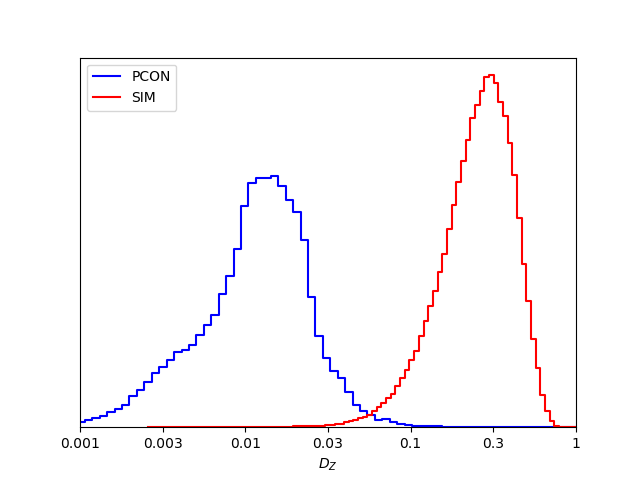

In [77]:
fig=plt.figure()
ax=fig.gca()

hp,xp=medHistogram(np.log10(adata["DZpcon"].values),bins=100,density=True)
hs,xs=medHistogram(np.log10(adata["DZsim"].values),bins=100,density=True)

ax.step(xp,hp,color='b',label="PCON")
ax.step(xs,hs,color='r',label="SIM")

ax.set_xlabel(r"$D_Z$")

xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()

ax.set_xlim((-3,0))
ax.set_ylim((0,ymax))

xts=ax.get_xticks()
xtl=[]
for xt in xts:
    xtl+=[f"{10**xt:.1g}"]
ax.set_xticklabels(xtl)
ax.set_yticks([])

ax.legend(loc='upper left')

fig.savefig(f"{FIGDIR}/fig-compare_NUM_SIM_PCON.png")

In [82]:
comparison=["DZpcon","q","q_pcon","e","e_pcon","i","i_pcon","Omega","W_pcon","omega","w_pcon"]
adata.sort_values(by="DZpcon",ascending=False)[comparison].head(50)

,DZpcon,q,q_pcon,e,e_pcon,i,i_pcon,Omega,W_pcon,omega,w_pcon
4093,1.586169,0.020495,0.022495,0.745823,0.957765,71.708171,66.017167,98.909082,78.660697,345.437834,357.457713
1474,1.570505,0.029980,0.036841,0.668394,0.930426,58.703667,59.169570,131.458720,141.445578,193.248382,176.032390
4096,1.520115,0.021420,0.023199,0.758908,0.956402,19.803366,17.684755,113.183395,95.808664,320.316126,357.473636
1726,1.337384,0.037475,0.040510,0.697630,0.923173,27.576285,26.060204,95.937518,106.920616,191.303908,175.842912
4094,1.306058,0.021055,0.021787,1.166800,0.959024,12.014117,11.811102,117.351642,99.631428,326.209887,357.485105
1472,1.222047,0.027963,0.035526,0.788113,0.932886,56.929579,58.741489,132.926900,142.453954,196.125174,176.068554
3994,1.074713,0.034989,0.034274,1.185732,0.940129,8.952256,9.551818,291.034417,276.648878,169.180941,186.177707
3992,1.048784,0.037601,0.035984,1.189980,0.937064,14.529080,15.453302,295.028854,282.387205,172.579145,186.223245
3279,1.030984,0.030258,0.020439,1.162073,0.964330,16.354519,18.397306,239.756329,248.778497,1.455958,5.986427
3992,1.024388,0.036690,0.035647,1.181915,0.937663,13.792276,14.521588,294.748980,281.432531,170.059420,186.208925
